# 0.0. IMPORTS

In [88]:
import pandas  as pd
import numpy   as np
import seaborn as sns

import math
import datetime
import inflection

from scipy      import stats  as ss
from matplotlib import pyplot as plt

from boruta                import BorutaPy
from tabulate              import tabulate
from IPython.display       import Image
from IPython.core.display  import HTML
from sklearn.ensemble      import RandomForestRegressor
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

## 0.1. Helper Functions

In [2]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).as_matrix()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k - 1)*(r - 1) / (n - 1))
    
    kcorr = k - (k - 1)**2 / (n - 1)
    rcorr = r - (k - 1)**2 / (n - 1)
    
    return np.sqrt((chi2corr / n) / (min(kcorr - 1, rcorr - 1))) 

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [4]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Data

In [5]:
df_sales_raw = pd.read_csv('datasets/train.csv', low_memory=False)

In [6]:
df_store_raw = pd.read_csv('datasets/store.csv', low_memory=False)

In [7]:
# Merge Datasets
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [8]:
# Plot random line only to check
#df_raw.sample()

# 1.0. DATA DESCRIPTION

In [9]:
df1 = df_raw.copy()

## 1.1. Columns Descriptions

* **Id** - an Id that represents a (Store, Date) duple within the test set
* **Store** - a unique Id for each store
* **Sales** - the turnover for any given day (this is what you are predicting)
* **Customers** - the number of customers on a given day
* **Open** - an indicator for whether the store was open: 0 = closed, 1 = open
* **StateHoliday** - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* **SchoolHoliday** - indicates if the (Store, Date) was affected by the closure of public schools
* **StoreType** - differentiates between 4 different store models: a, b, c, d
* **Assortment** - describes an assortment level: a = basic, b = extra, c = extended
* **CompetitionDistance** - distance in meters to the nearest competitor store
* **CompetitionOpenSince\[Month\/Year\]** - gives the approximate year and month of the time the nearest competitor was opened
* **Promo** - indicates whether a store is running a promo on that day
* **Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* **Promo2Since\[Year\/Week\]** - describes the year and calendar week when the store started participating in Promo2
* **PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

## 1.2. Rename Columns 

In [10]:
# Nome das colunas
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 
            'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 
            'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 
            'Promo2SinceYear', 'PromoInterval']

In [11]:
# Função que irá alterar o nome das colunas para o padrão snake_case
snakecase = lambda x: inflection.underscore(x)

In [12]:
# Aplicação da função anterior.
# Utilizamos a função *map* para aplicarmos a função *snakecase* em todos 
# os itens da lista *cols_old*. O resultado disso deverá ser transformado
# em uma lista
cols_new = list(map(snakecase, cols_old))

In [13]:
# Renomeia as colunas do DF
df1.columns = cols_new

## 1.3. Data Dimension 

In [14]:
print(f"Number of Rows: {df1.shape[0]}")
print(f"Number of Columns: {df1.shape[1]}")

Number of Rows: 1017209
Number of Columns: 18


## 1.4. Data Types 

In [15]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [16]:
df1['date'] = pd.to_datetime(df1['date'])

In [17]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.5. Check NA 

In [18]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.6. Fillout NA

### 1.5.1. competition_distance

In [19]:
df1['competition_distance'].max()

75860.0

In [20]:
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

### 1.5.2. competition_open_since_month

In [21]:
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

### 1.5.3. competition_open_since_year

In [22]:
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

### 1.5.4. promo2_since_week

In [23]:
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

### 1.5.5. promo2_since_year

In [24]:
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

### 1.5.6. promo_interval

In [25]:
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
             7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

In [26]:
df1['promo_interval'].fillna(0, inplace=True)

In [27]:
df1['month_map'] = df1['date'].dt.month.map(month_map)

In [28]:
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

### 1.5.7. Checking NA

In [29]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.7. Change Types

In [30]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [31]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [32]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.8. Descriptive Statistics

### 1.8.1. Categorical and Numeric Separation

In [33]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.8.2. Numerical Attributes

#### 1.8.2.1. Central Tendency

In [34]:
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#### 1.8.2.2. Dispersion Tendency

In [35]:
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#### 1.8.2.3. Dispersions Concatenation 

In [36]:
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d6, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-1.200524,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,-1.246873,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,1.778375,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,7.091773,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,1.090723,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,-1.762018,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,0.815154,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,147.789712,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-1.232607,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,124.071304,124.071304


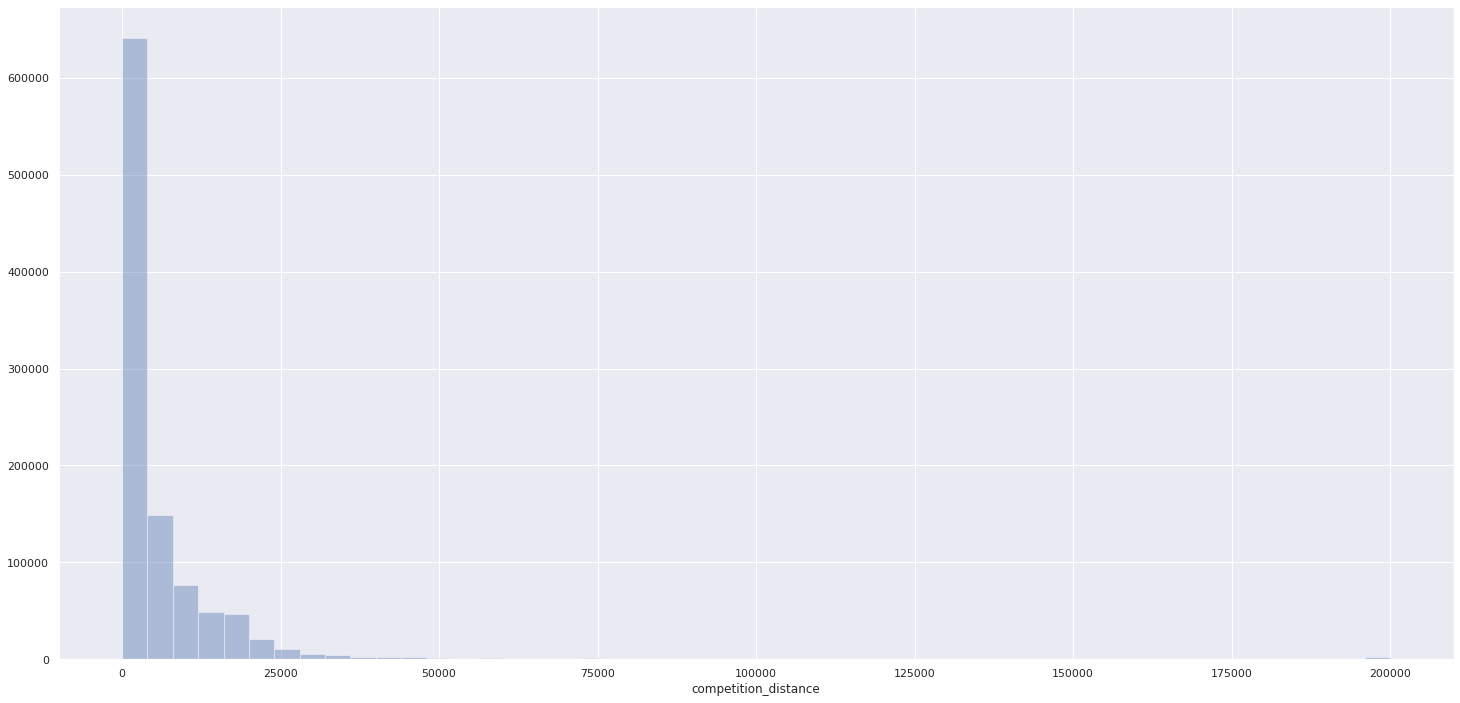

In [37]:
sns.distplot( df1['competition_distance'], kde=False );

### 1.8.3. Categorical Attributes

In [38]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

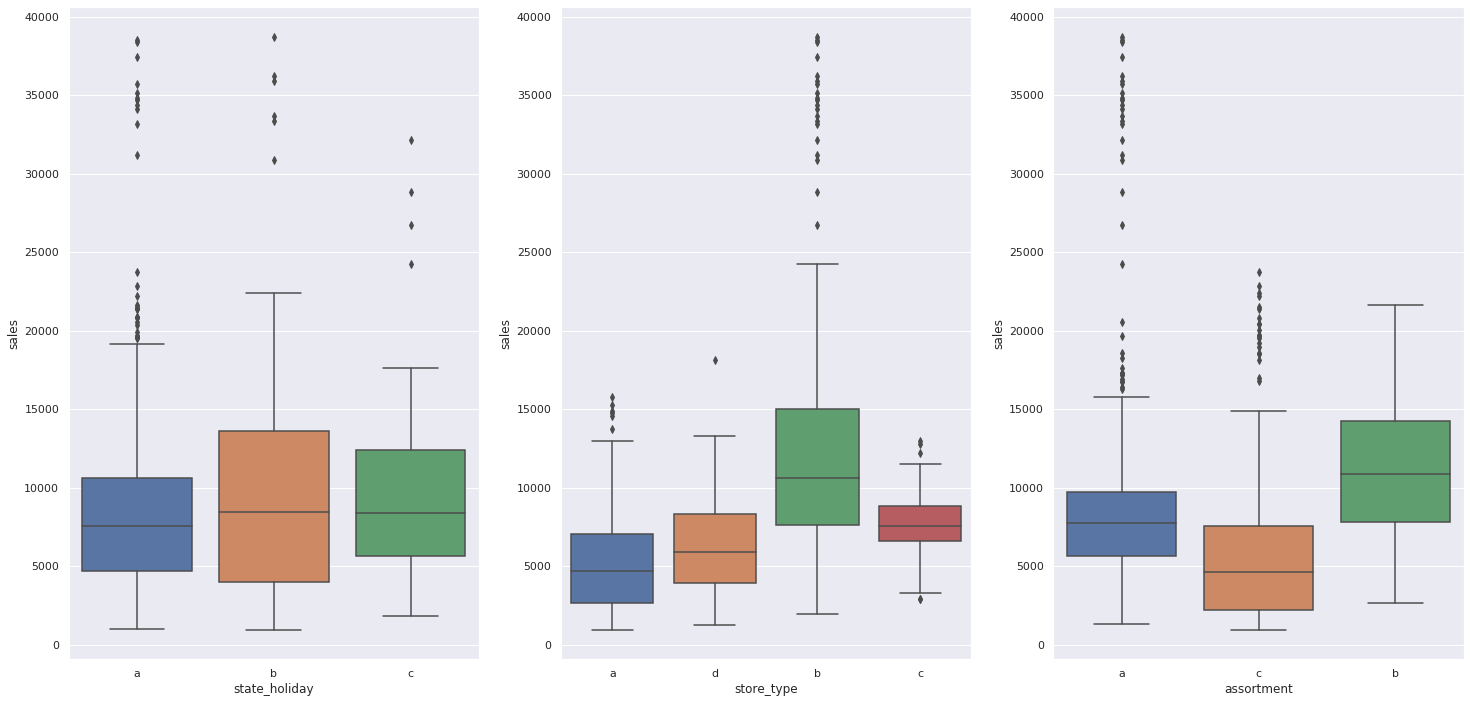

In [39]:
aux1 = df1[ (df1['sales'] > 0) & (df1['state_holiday'] != '0') ]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1)

# 2.0. FEATURE ENGINEERING

In [40]:
df2 = df1.copy()

## 2.1. Mind Map Hypothesis

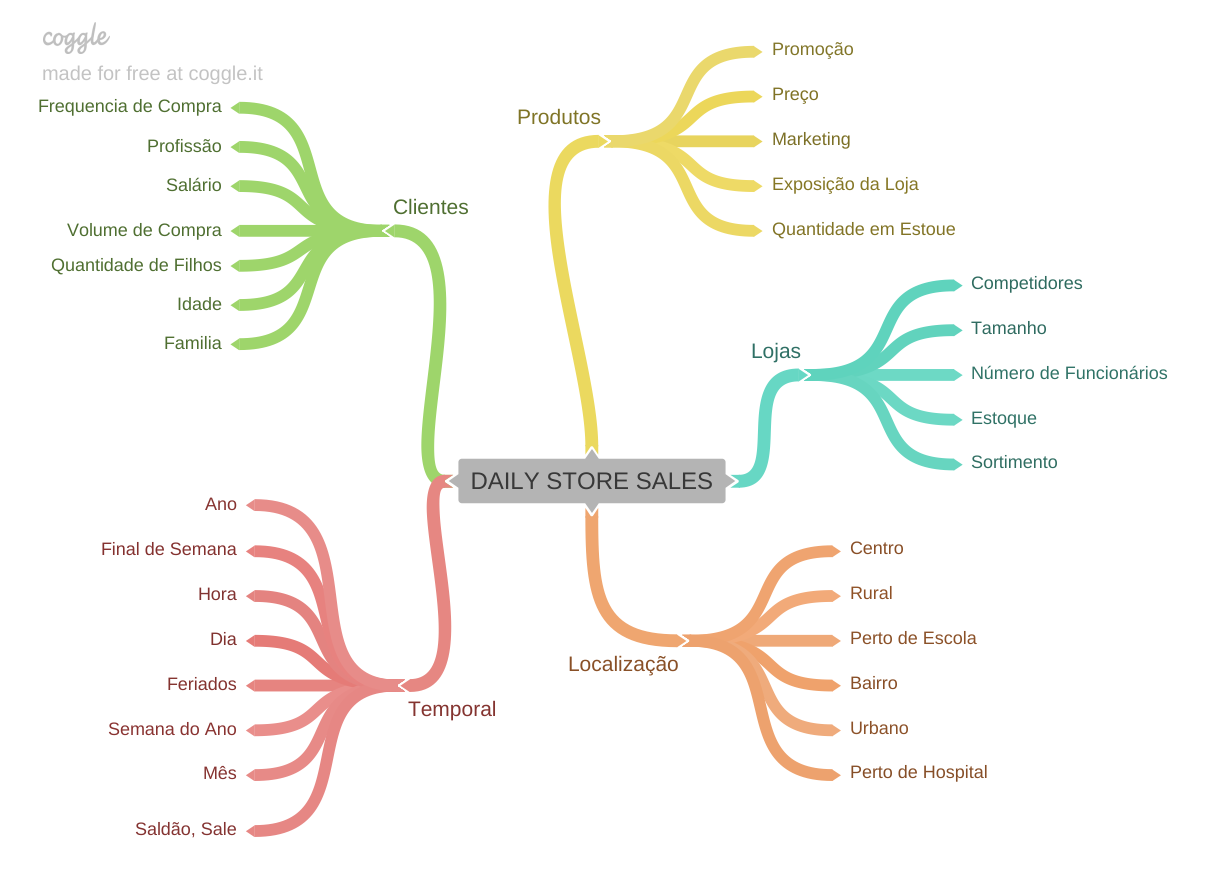

In [41]:
Image('images/mind_map_hypothesis.png')

## 2.2. Hypotesis

### 2.2.1. Store Hypotesis

**1.** Lojas com Maior Número de funcionários deveriam vender mais

**Não possuímos a quantidade de funcionários no Dataset**

**2.** Lojas com maior capacidade de estoque maior deveriam vender mais

**Não possuímos o tamanho do estoque no Dataset**

**3.** Lojas com maior porte deveriam vender mais

**Não possuímos o porte da loja no Dataset**

**4.** Lojas com maior sortimento de produtos vender mais

**Possuímos o tipo de sortimento das lojas, separadas por categorias. Coluna _Assortment_**

**5.** Lojas com competidores mais próximos deveriam vender menos

**Possuímos a distancia das lojas e seus competidores mais próximos. Coluna _CompetitionDistance_**

**6.** Lojas com competidores à mais tempo deveriam vender mais

**Possuímos o tempo decorrido da abertura dos competidores perto das lojas. Colunas _CompetitionOpenSince\[Month\/Year\]_**

### 2.2.2. Product Hypotesis

**1.** Lojas que investem mais em marketing deveriam vender mais

**Não possuímos o budget de investimento em marketing das lojas no Dataset**

**2.** Lojas com maior exposição dos produtos deveriam vender mais


**Não possuímos a quantidade de produtos expostas nas lojas no Dataset**

**3.** Lojas com produtos com preços menores deveriam vender mais

**Não possuímos o preço dos produtos das lojas no Dataset**

**4.** Lojas com descontos mais agressios (preços menores) deveriam vender mais

**Não possuímos o valor do descont das lojas no Dataset**

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais

**Possuímos colunas para verificar o tempo decorrido que uma loja esteve em promoção. Colunas _Promo2_ , _Promo2Since\[Year\/Week\]_ , _PromoInterval_**

**6.** Lojas com mais dias em promoção deveriam vender mais

**Possuímos colunas para verificar o tempo decorrido que uma loja esteve em promoção. Colunas _Promo2_ , _Promo2Since\[Year\/Week\]_ , _PromoInterval_**

**7.** Lojas com mais promoções consecutivas deveriam vender mais

**Possuímos colunas para verificar o tempo decorrido que uma loja esteve em promoção. Colunas _Promo2_ , _Promo2Since\[Year\/Week\]_ , _PromoInterval_**

### 2.2.3. Temporal Hypotesis

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais

**Possuímos colunas para verificar se as lojas estiveram abertas em feriados e em quais feriados. Colunas _Open_ , _StateHoliday_**

**2.** Lojas deveriam vender mais ao longo dos anos

**Possuímos uma coluna que pode ser derivada e criada uma nova coluna para validarmos essa hipótese. Coluna _date_**

**3.** Lojas deveriam vender mais no segundo semestre do ano

**Possuímos uma coluna que pode ser utilizada para validarmos essa hipótese. Coluna _date_**

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês

**Possuímos uma coluna que pode ser utilizada para validarmos essa hipótese. Coluna _date_**

**5.** Lojas deveriam vender menos aos finais de semana

**Possuímos uma coluna que pode ser utilizada para validarmos essa hipótese. Coluna _date_**

**6.** Lojas deveriam vender menos durante os feriados escolares

**Possuímos uma coluna que pode ser utilizada para validarmos essa hipótese. Coluna _date_**

## 2.3. Chosen Hypotesis

**1.** Lojas com maior sortimento de produtos vender mais

**2.** Lojas com competidores mais próximos deveriam vender menos

**3.** Lojas com competidores à mais tempo deveriam vender mais

**4.** Lojas com prmnoções ativas por mais tempo deveriam vender mais

**5.** Lojas com mais dias em promoção deveriam vender mais

**6.** Lojas com mais promoções consecutivas deveriam vender mais

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais

**8.** Lojas deveriam vender mais ao longo dos anos

**9.** Lojas deveriam vender mais no segundo semestre do ano

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês

**11.** Lojas deveriam vender menos aos finais de semana

**12.** Lojas deveriam vender menos durante os feriados escolares

## 2.4. Feature Engineering

In [42]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

# 3.0. FILTERING FEATURES

In [43]:
df3 = df2.copy()

## 3.1. Filtering Lines

In [44]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Columns Selection

In [45]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map'] 

In [46]:
df3.drop(cols_drop, axis=1, inplace=True)

# 4.0. EDA - EXPLORATORY DATA ANALYSIS

In [47]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Response Variable

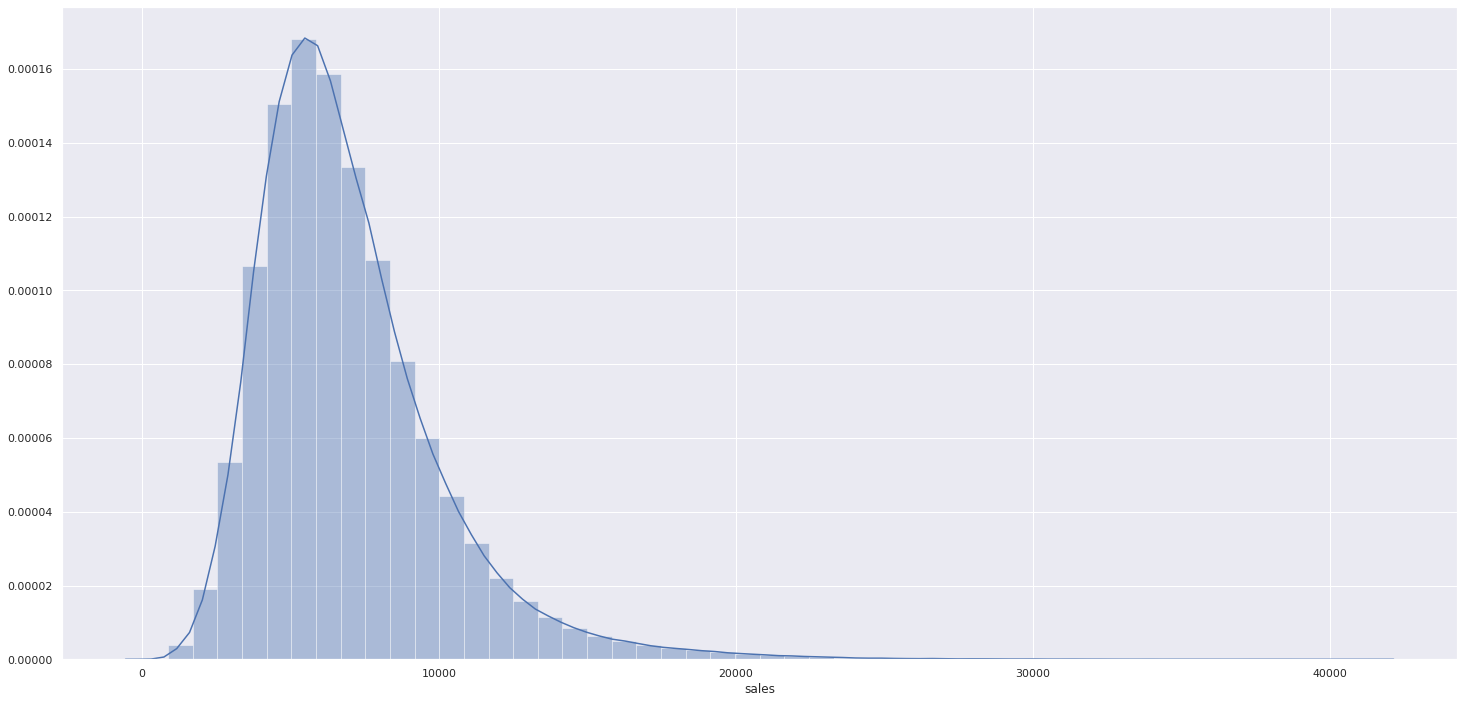

In [48]:
sns.distplot(df4['sales'])

### 4.1.2. Numerical Variable

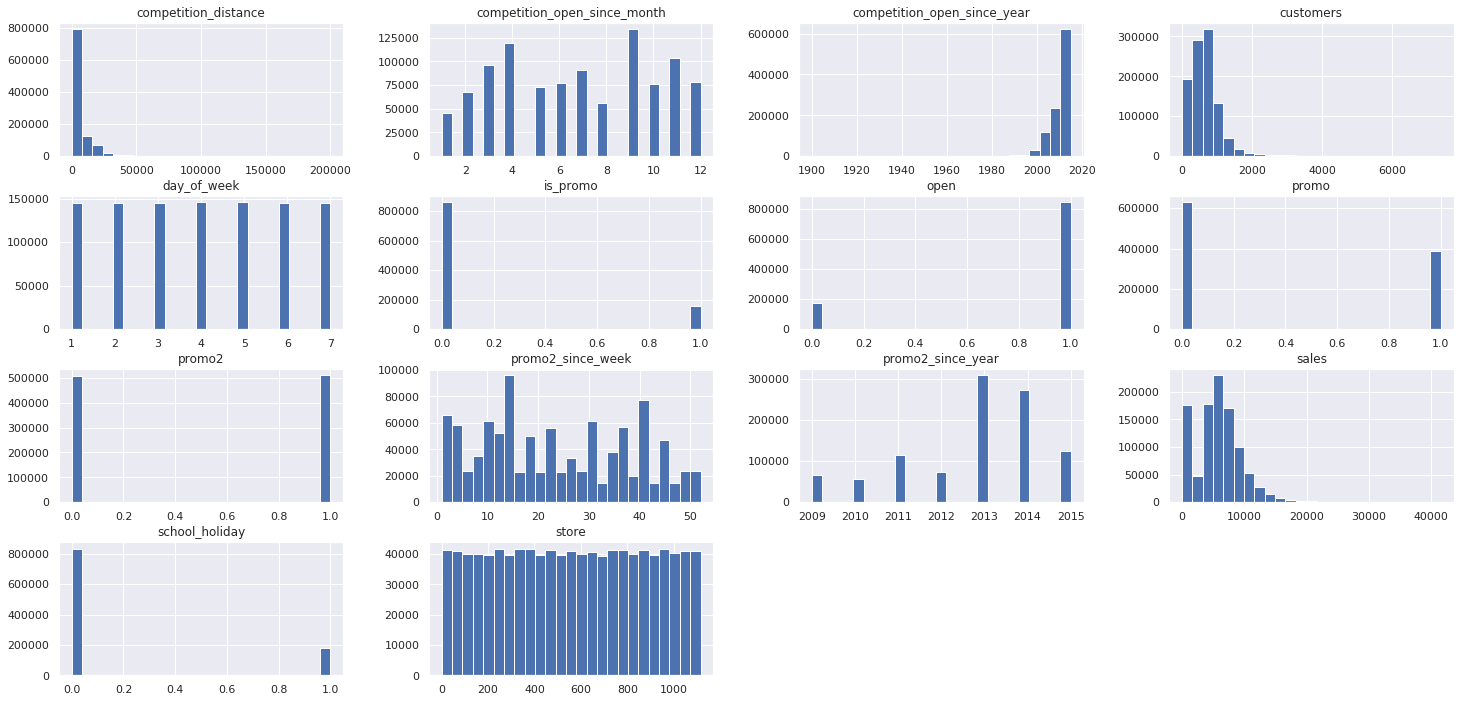

In [49]:
num_attributes.hist(bins=25);

### 4.1.3. Categorical Variables

In [50]:
df4['state_holiday'].drop_duplicates()
df4['store_type'].drop_duplicates()
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

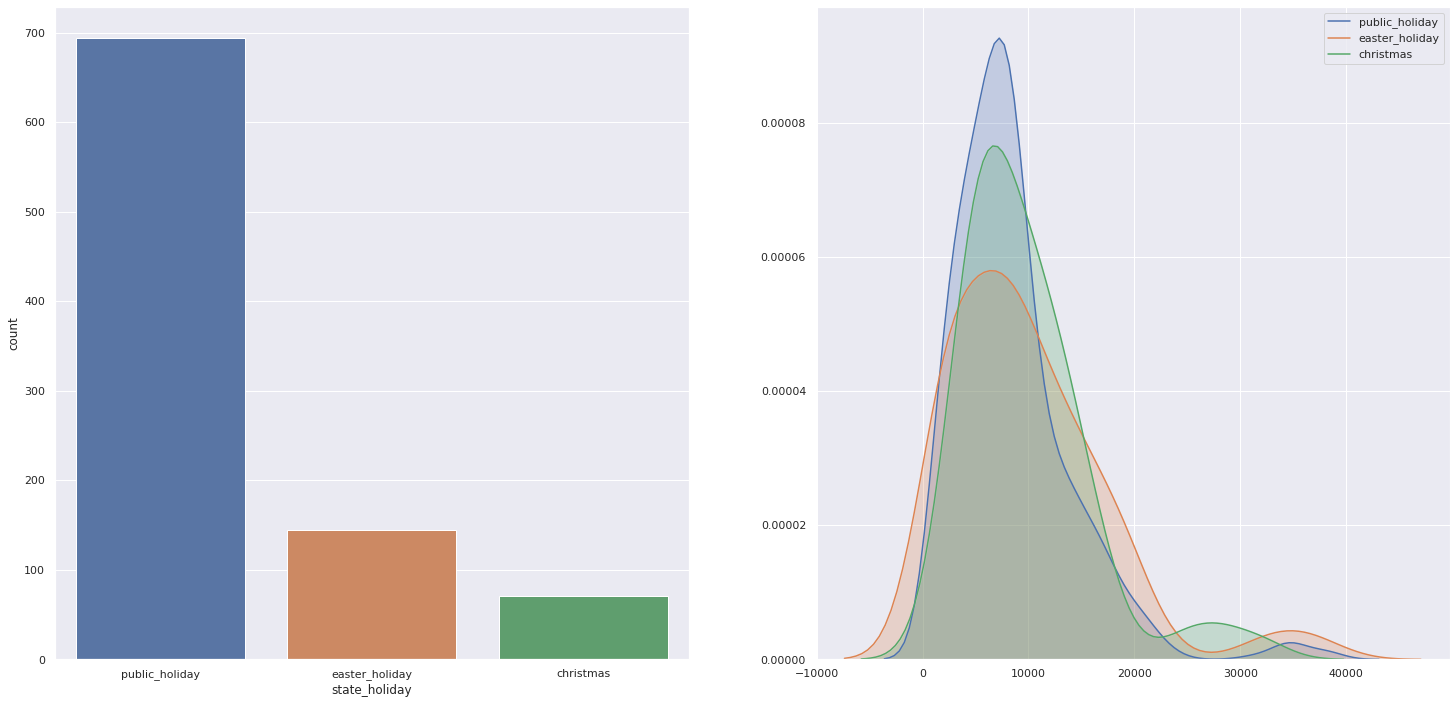

In [51]:
# state holliday
plt.subplot(1, 2, 1)
hollidays = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(hollidays['state_holiday'])

plt.subplot(1, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True);

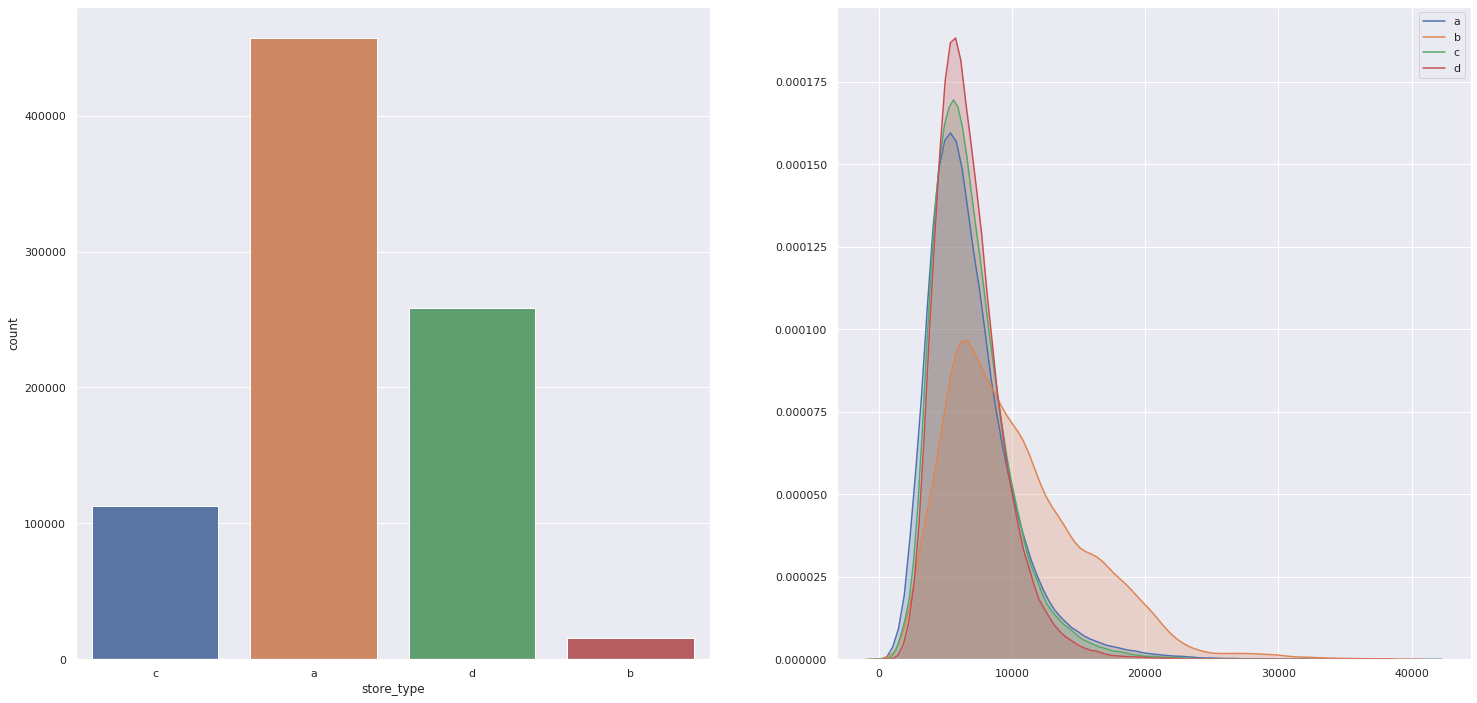

In [52]:
# store type
plt.subplot(1, 2, 1)
sns.countplot(df4['store_type'])

plt.subplot(1, 2, 2)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True);

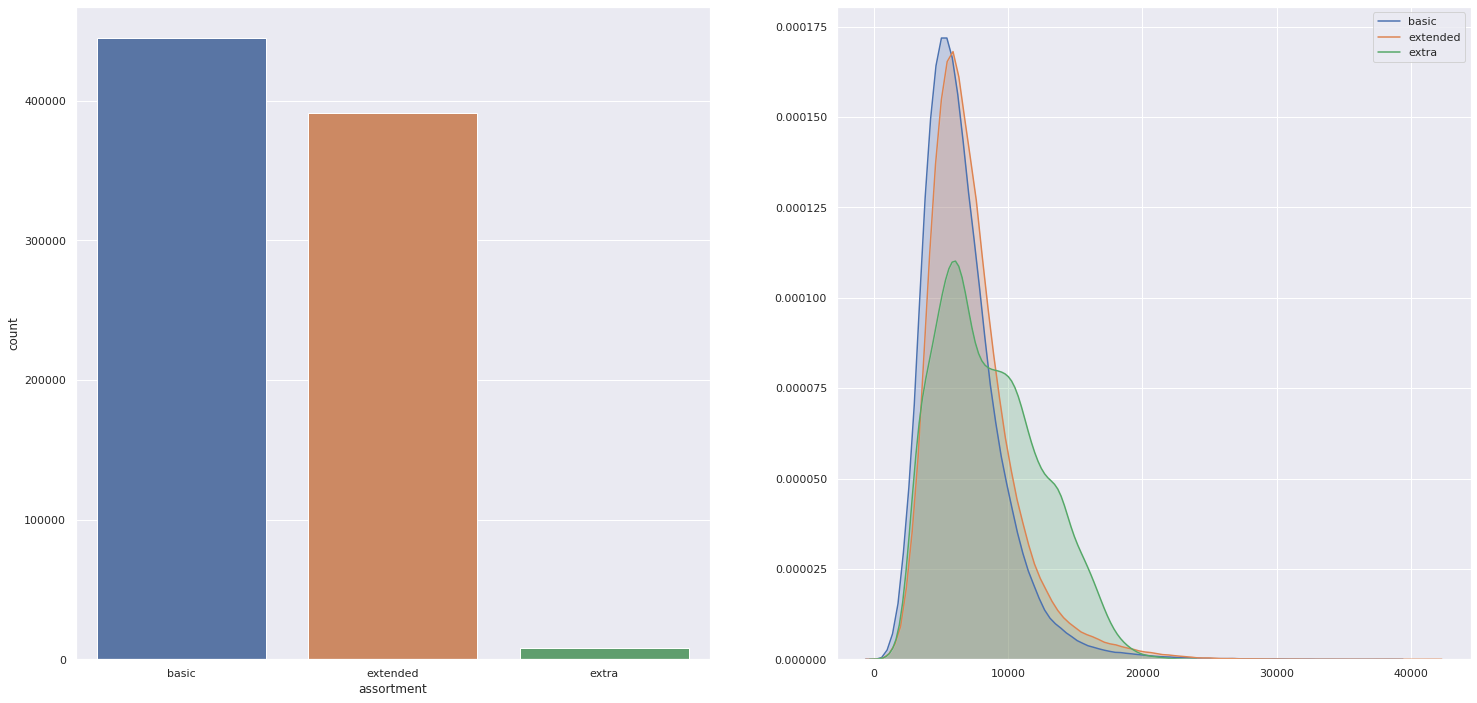

In [53]:
# assortment
plt.subplot(1, 2, 1)
sns.countplot(df4['assortment'])

plt.subplot(1, 2, 2)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True);

## 4.2. Bivariate Analysis

### 4.2.1. Hypotesis 1 - Lojas com maior sortimento de produtos vender mais
**FALSA** Lojas com MAIOR SORTIMENTO vendem MENOS

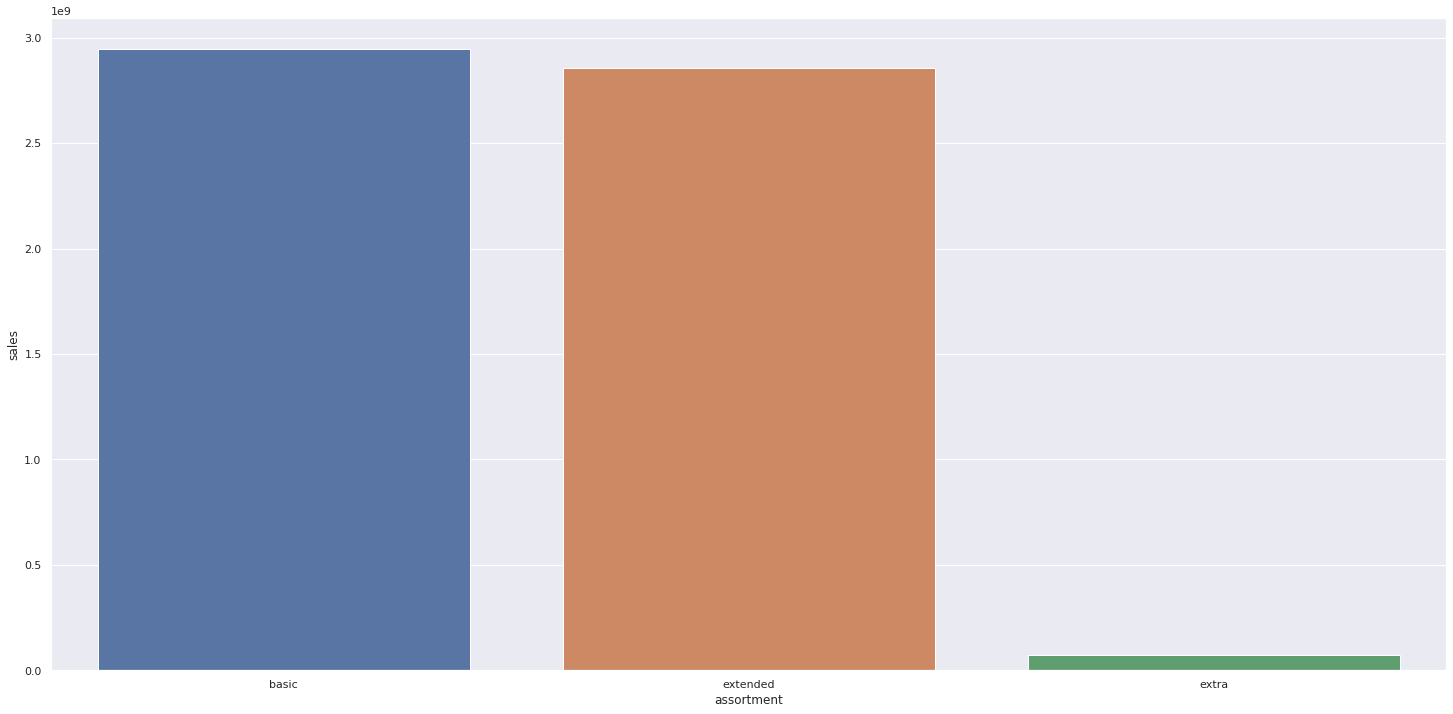

In [54]:
# Gráfico de Barras para comparar a soma das vendas por tipo de sortimento
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

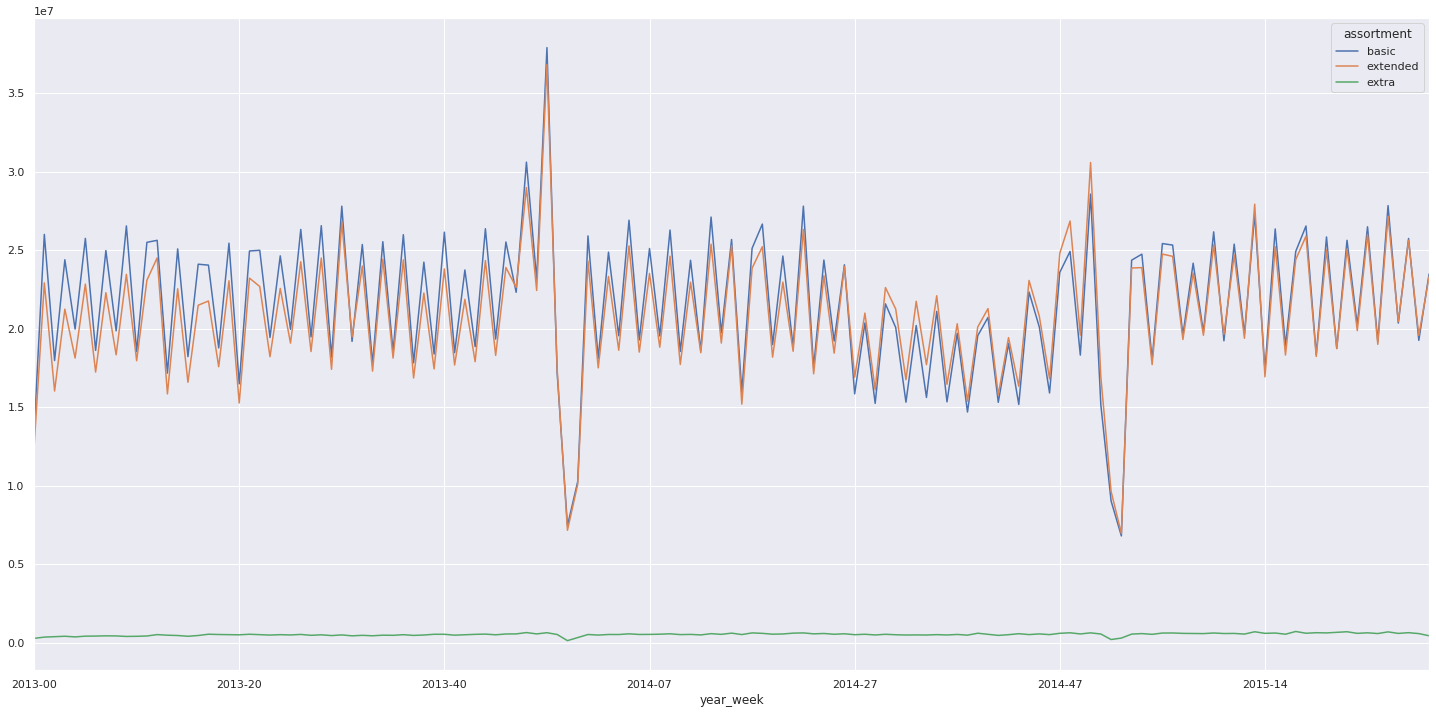

In [55]:
# Gráfico Temporal para demonstrar a variação das vendas por sortimento ao longo dos anos
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot();

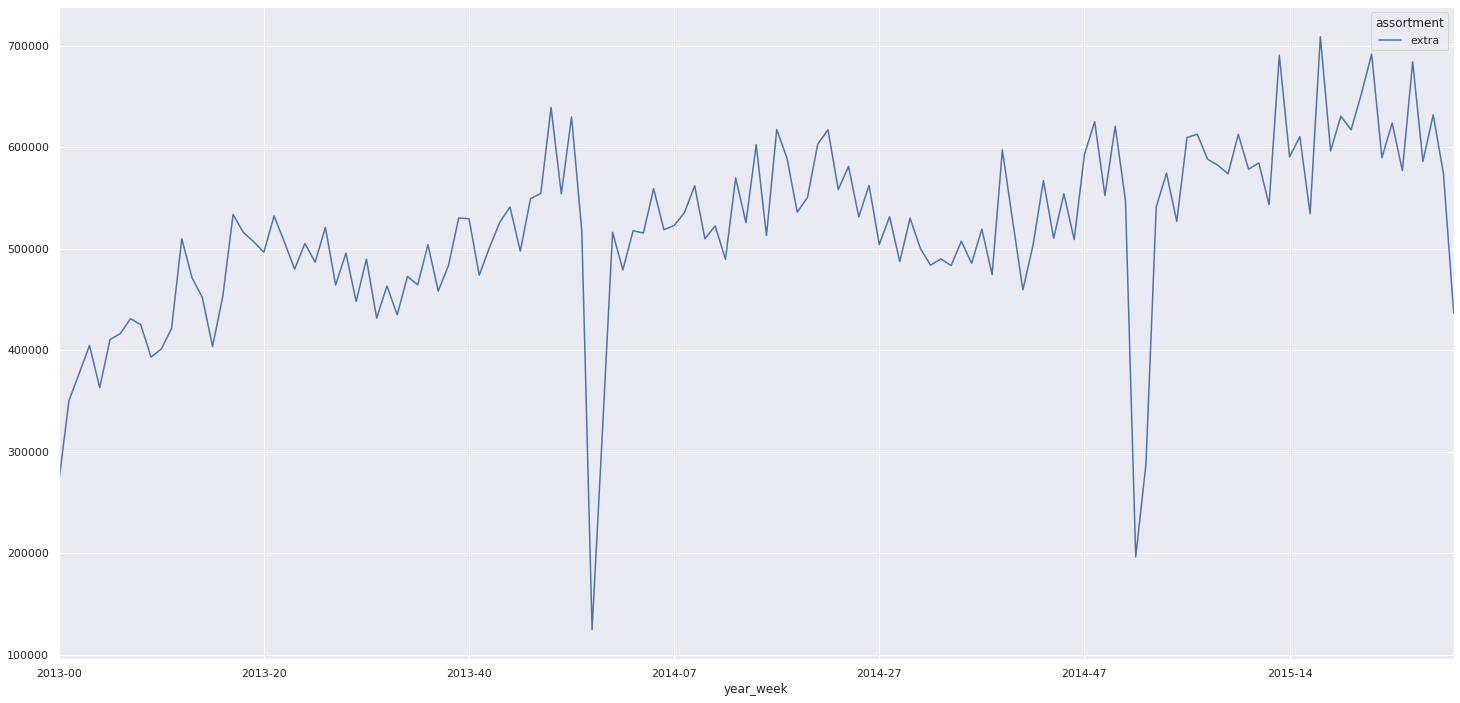

In [56]:
# Gráfico Temporal para mostrar a variação das vendas quando o sortimento for igual a extra
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot();

### 4.2.2. Hypotesis 2 - Lojas com competidores mais próximos deveriam vender menos
**FALSA** Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MENOS.

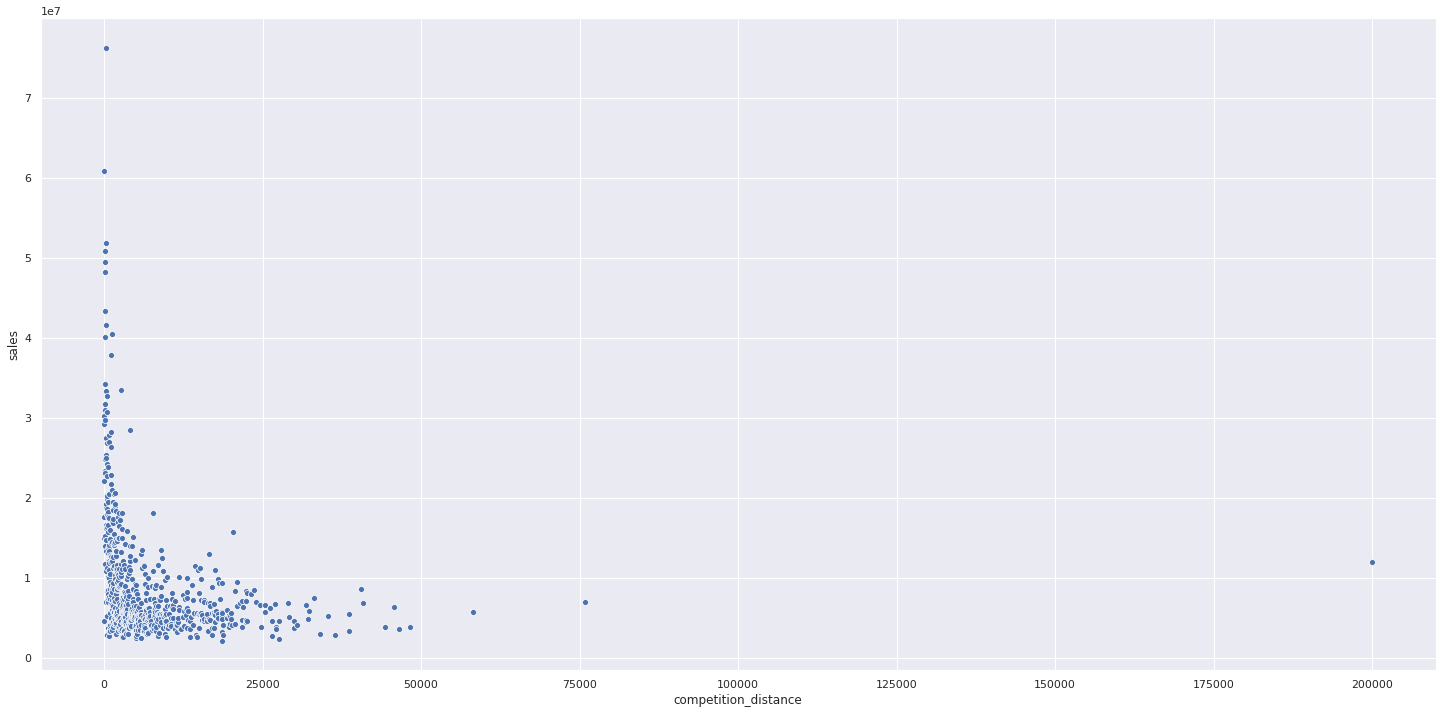

In [57]:
# Gráfico de Distribuição de ponto para verificarmos a distribuição das vendas em relação a distancia do competidor
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

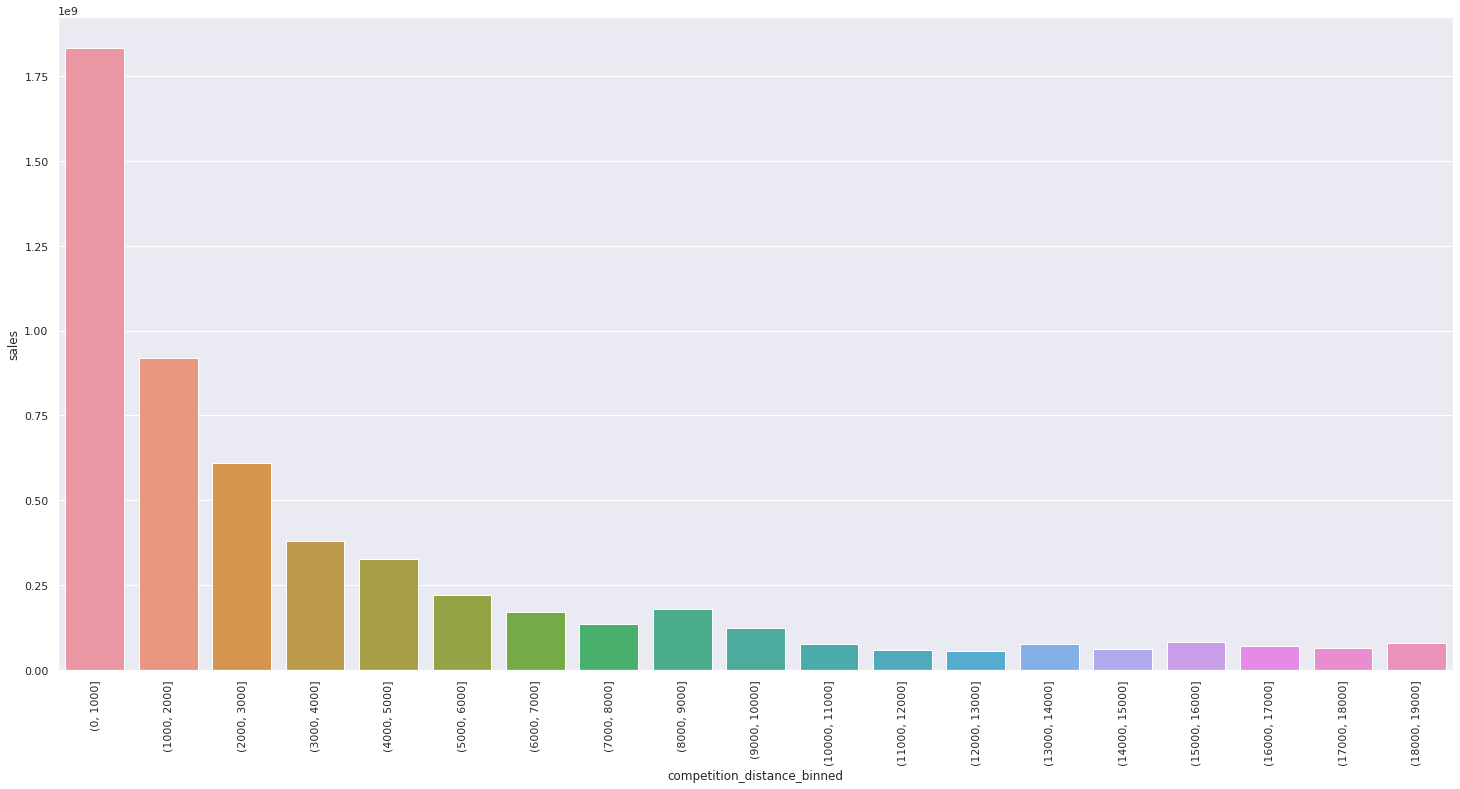

In [58]:
# Gráfico de Barras para podemor comparar a somatória das vendas por conjunto de competidores em certas distância
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90);

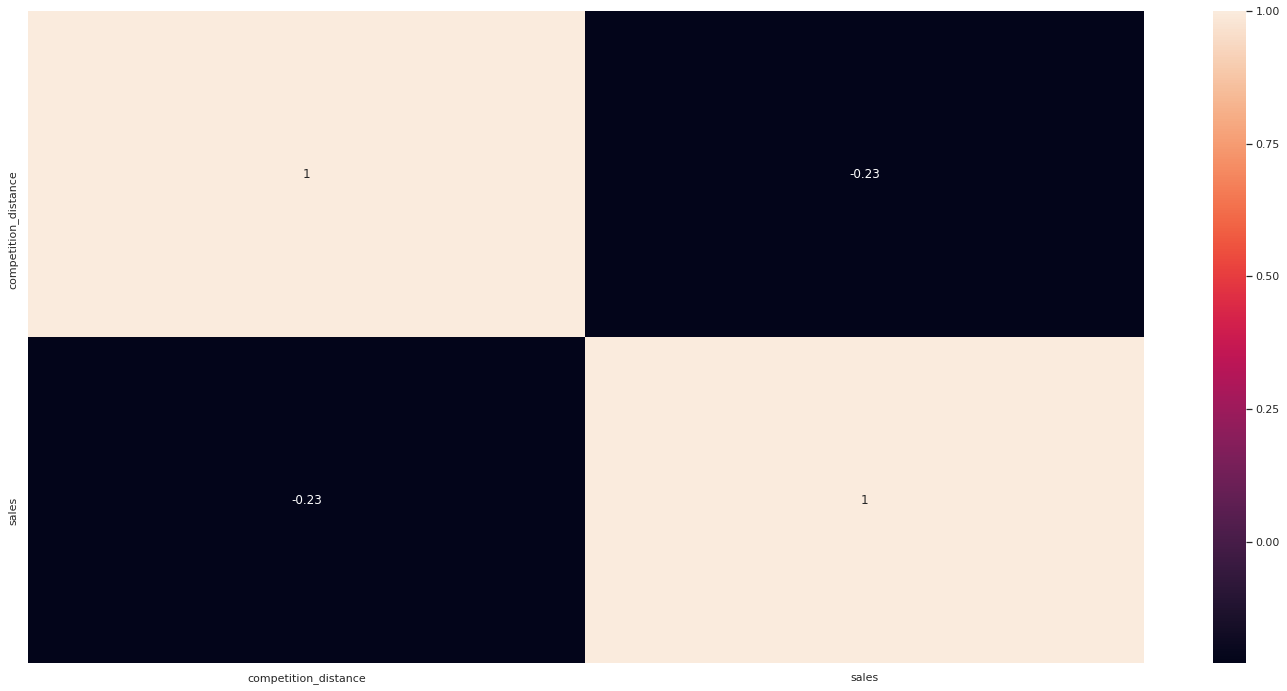

In [59]:
# Mapa de Calor para Medirmos a Correlação entre o Valor de Vendas e a Distância entre a loja e o competidor mais próximo
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### 4.2.3. Hypotesis 3 - Lojas com competidores à mais tempo deveriam vender mais
**FALSA** Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS

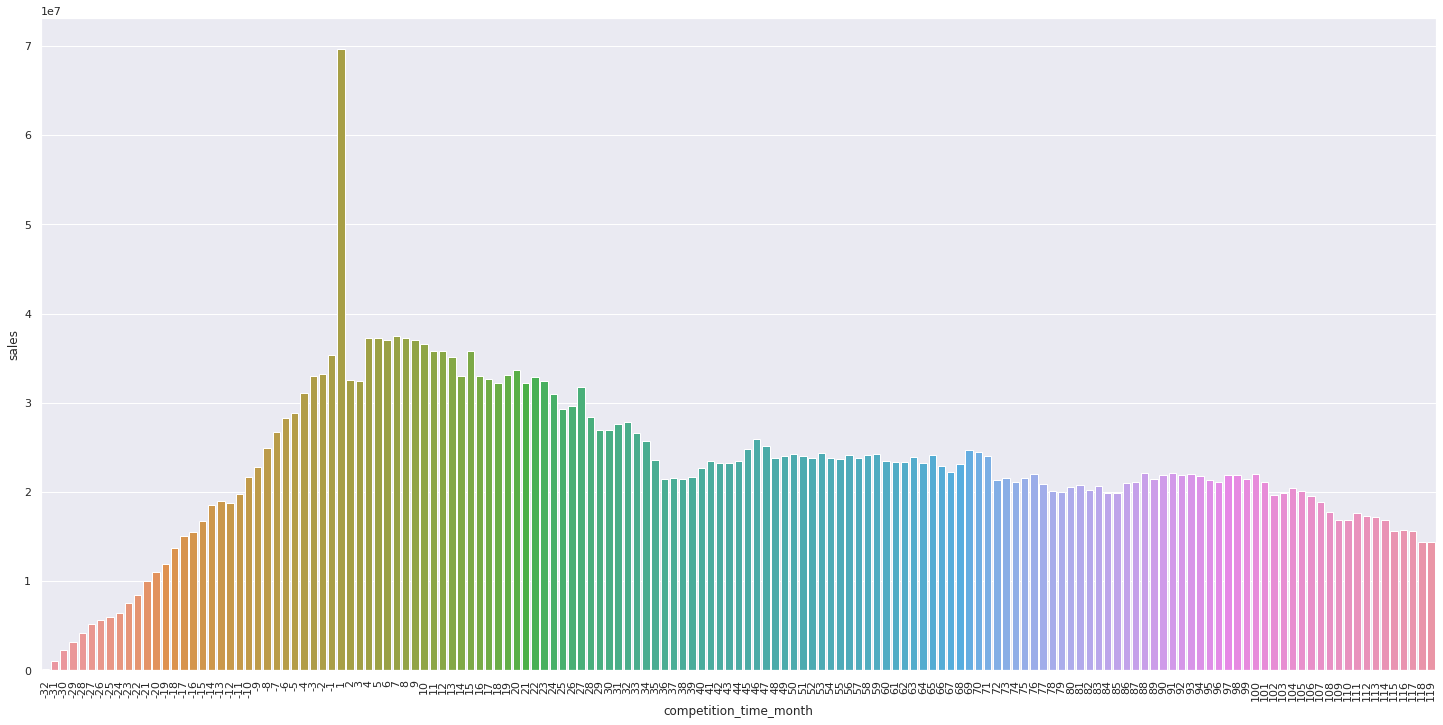

In [60]:
# Gráfico de Barras para compararmos as vendas conforme os competidores abriam e iniciavam a competição
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
# 120 Primeiros meses de competição e Tempo de competição diferente de Zero
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2)
plt.xticks(rotation=90);

# Valores negativos do eixo X representam que o competidor abriu depois de a loja ja ter iniciado a venda.
# Enquanto os valores positivos representam que o competidor ja existia no local antes de a loja abrir
# Dessa forma, podemos notar que quanto mais recente é o tempo de competição, maior são as vendas

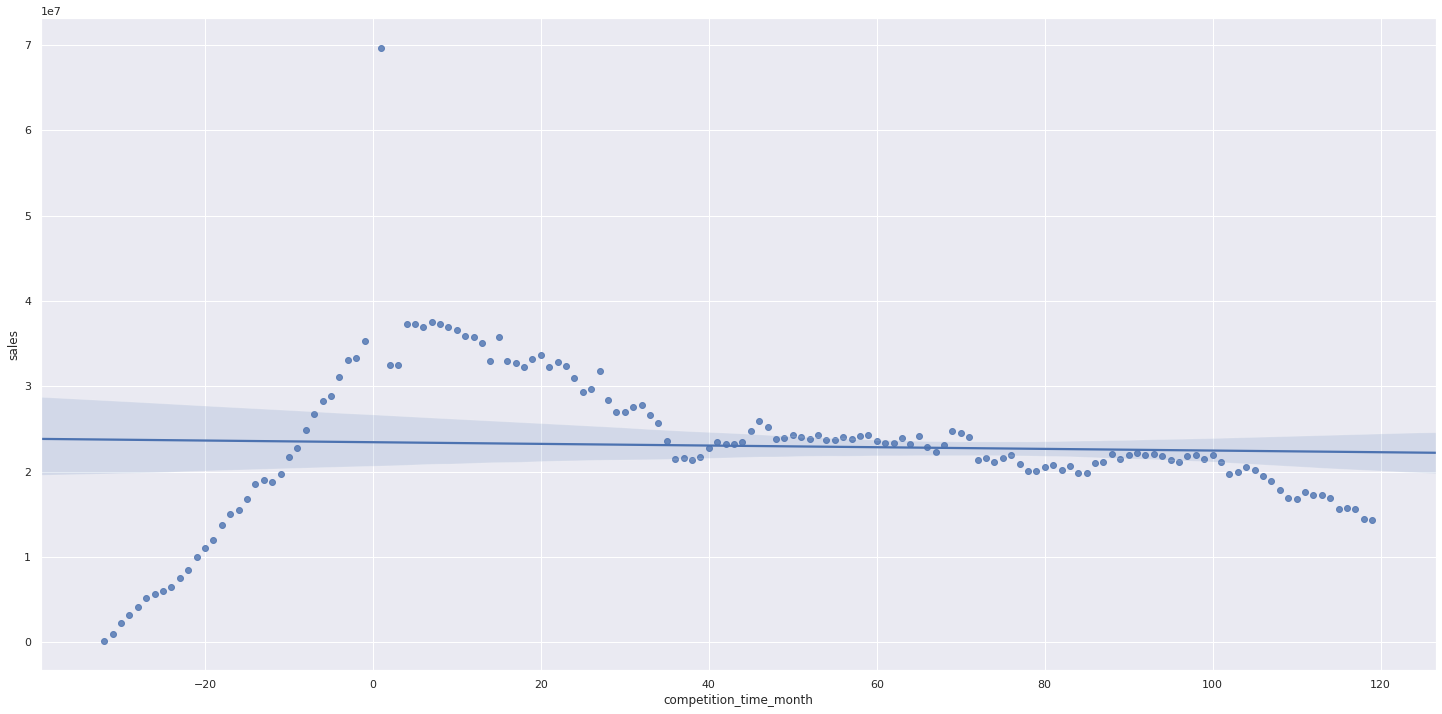

In [61]:
# Gráfico que demonstra a tendência de crescimento das vendas em relação ao tempo de competição.
sns.regplot(x='competition_time_month', y='sales', data=aux2);

# Como esse gráfico é um gráfico de tendência linear, e o comportamento das vendas não é linear,
# ou seja, o compartamento das vendas tanto decai quanto sobe ao longo do tempo, esse gráfico não
# deve ser utilizado para gerar qualquer tipo de conclusão, e sim, somente para auxiliar na leitura
# do comportamento geral e entendimento de outros gráficos

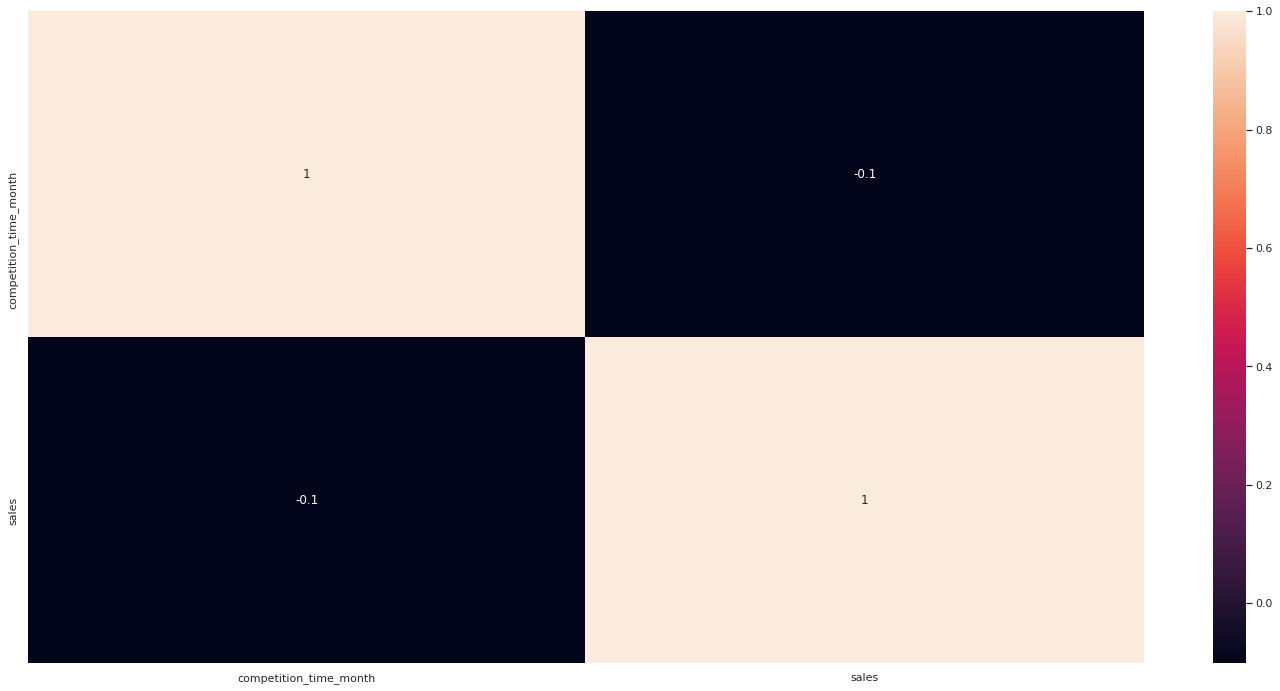

In [62]:
# Heatmap da correlação entre o tempo decorrido de competição com o valor das vendas
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### 4.2.4. Lojas com prmnoções ativas por mais tempo deveriam vender mais
**FALSA** lojas com PROMOÇÕES ATIVAS por mais tempo vendem MENOS, depois de um certo período de tempo

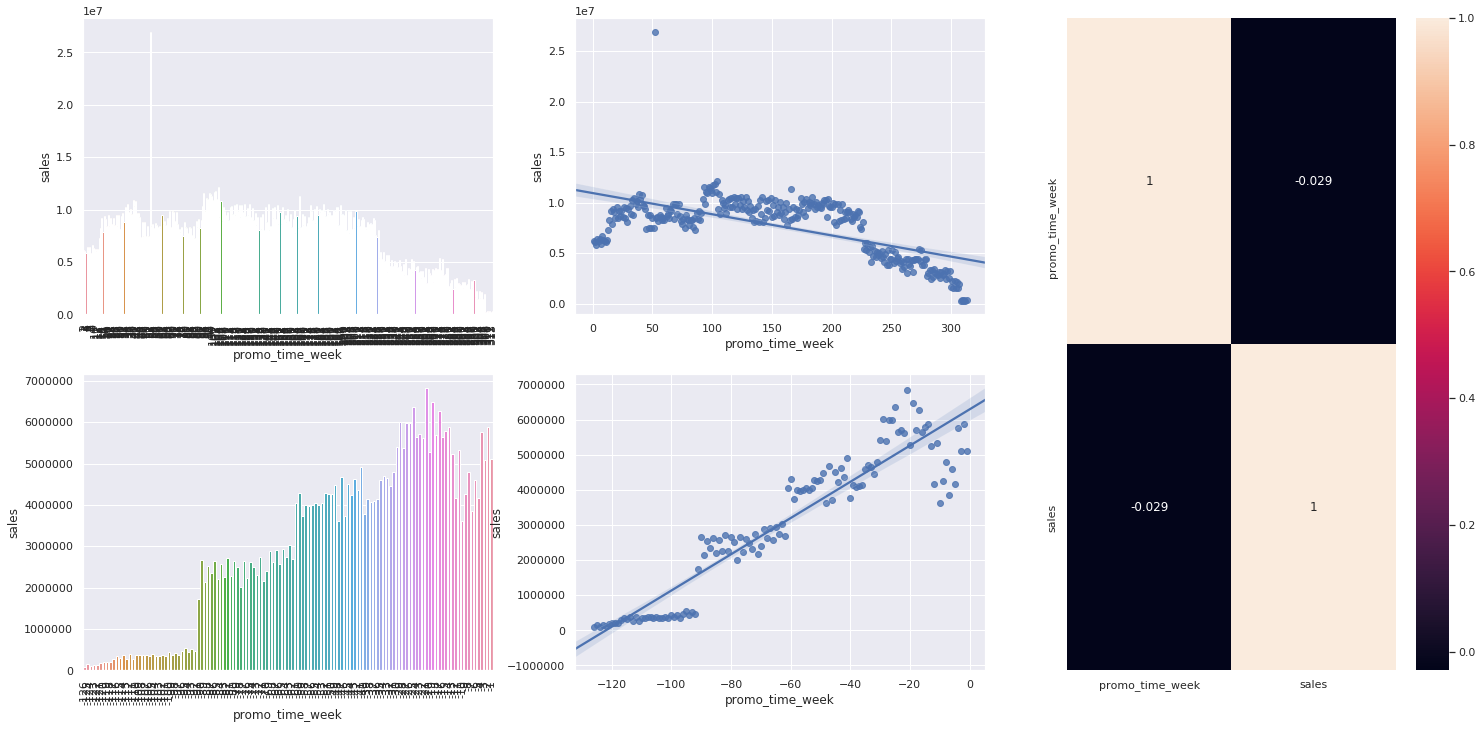

In [63]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

# Duas linhas e Três Colunas
grid = GridSpec(2, 3)

# Gráfico de Barras para comparar as vendas com relação ao tempo de promoção extendida
plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] # Promoção Extendida
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);

# Gráfico de Tendencia para verificarmos se a tendencia das vendas é crescente ou descrescente
plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2);


# Gráfico de Barras para comparar as vendas com relação ao tempo de promoção Regular
plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] # Promoção Regular
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);

# Gráfico de Tendencia para verificarmos se a tendencia das vendas é crescente ou descrescente
plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3);

# Mapa de Calor para verificarmos a correlação entre o tempo de promoção extendida e a quantiade de vendas
plt.subplot(grid[:, 2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### <s>4.2.5. Lojas com mais dias em promoção deveriam vender mais</s>
Será validada no próximo ciclo do CRISP

### 4.2.6. Lojas com mais promoções consecutivas deveriam vender mais
**FALSA** Lojas com mais promoções consecutivas vendem MENOS

In [64]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


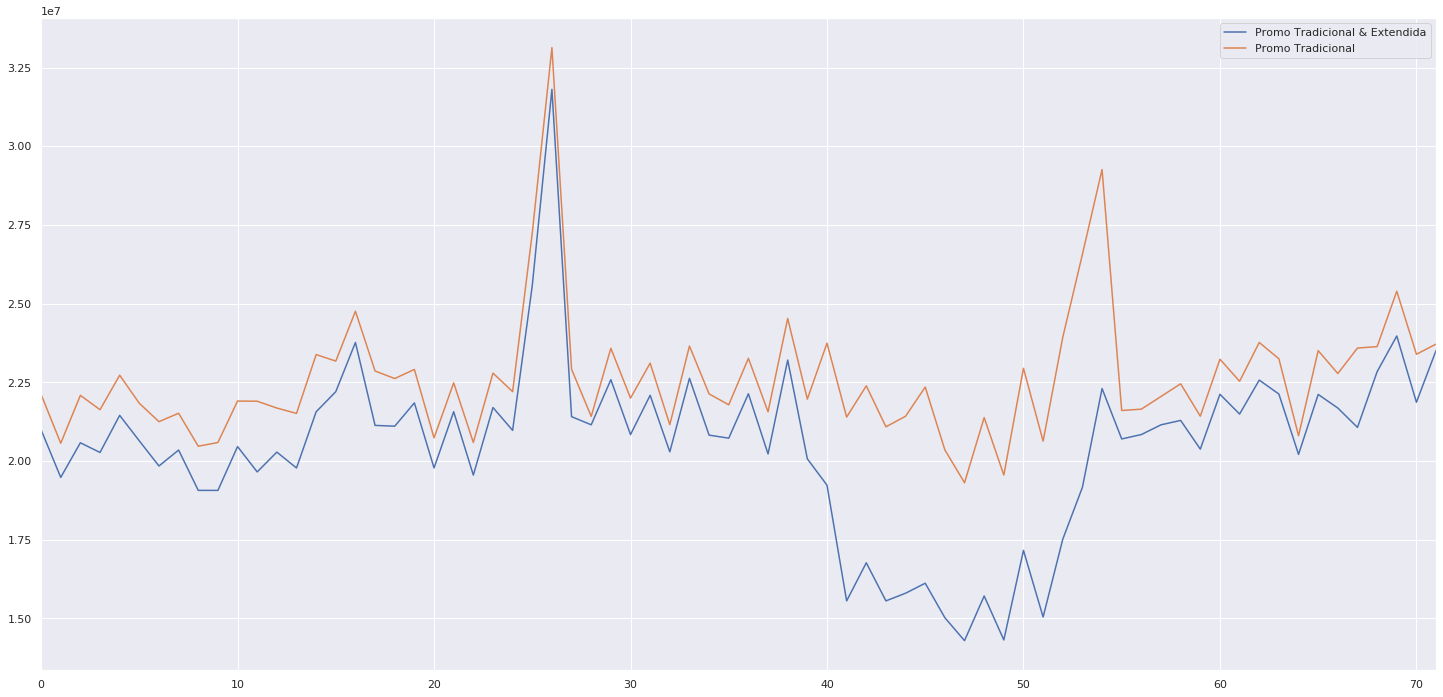

In [65]:
# Gráfico de linha para verificar o comportamento das vendas quando a loja está em promoção extendida ao longo do tempo
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

# Gráfico de linha para verificar o comportamento das vendas quando a loja está em promoção normal ao longo do tempo
aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax = ax)

# Adiciona as legendas
ax.legend(labels = ['Promo Tradicional & Extendida', 'Promo Tradicional']);

### 4.2.7. Lojas abertas durante o feriado de Natal deveriam vender mais
**FALSA** Lojas abertas durante o feriado de Natal Não vendem mais do que os outros feriados

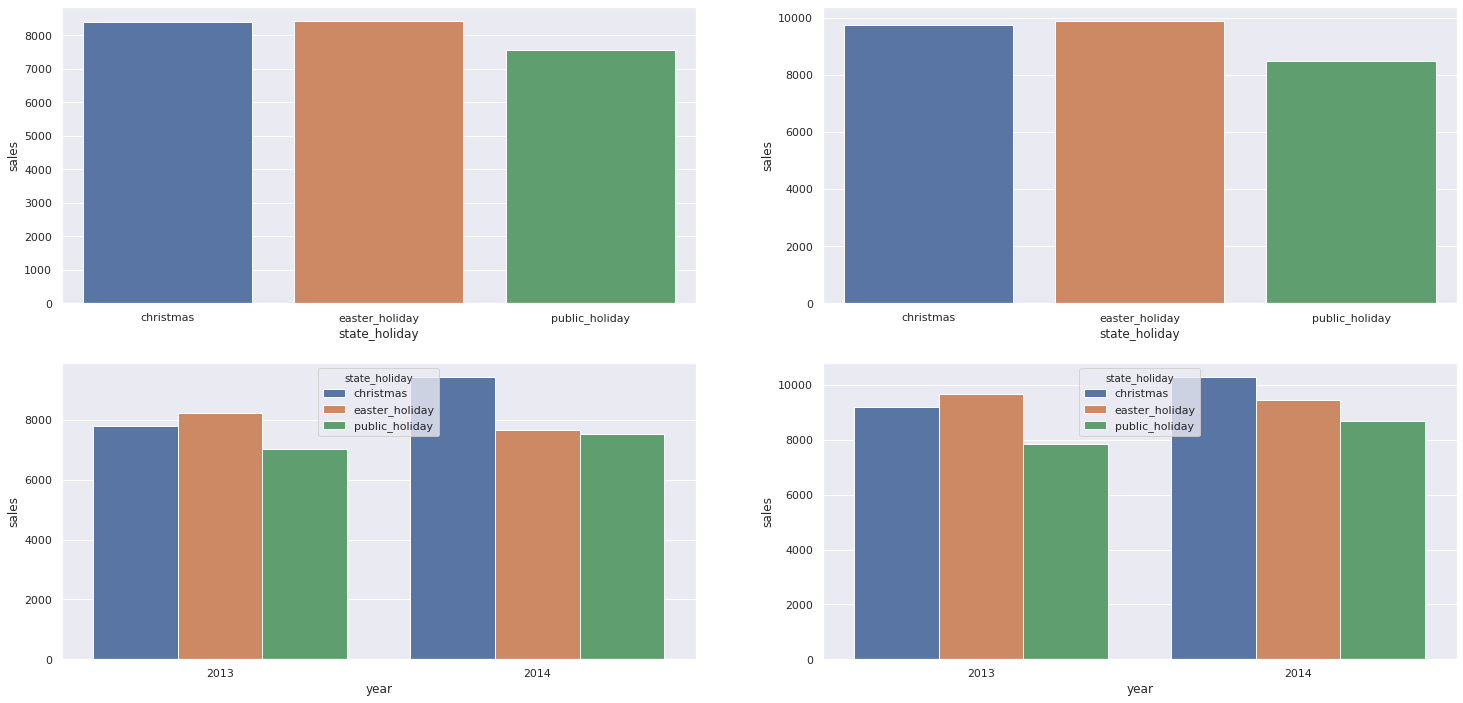

In [66]:
# Filtrando as linhas
aux = df4[df4['state_holiday'] != 'regular_day']

# Gráfico de Barras para comprar a mediana dos valores Gastos entre os tipos de feriados7
plt.subplot(2, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').median().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);

# Gráfico de Barras para comprar a média dos valores Gastos entre os tipos de feriados7
plt.subplot(2, 2, 2)
aux2 = aux[['state_holiday', 'sales']].groupby('state_holiday').mean().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux2);

#Gráfico de Barras para comprar a mediana dos valores gastos ao longo dos anos entre os tipos de feriados
plt.subplot(2, 2, 3)
aux3 = aux[aux['year'] != 2015][['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).median().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux3);

#Gráfico de Barras para comprar a média dos valores gastos ao longo dos anos entre os tipos de feriados
plt.subplot(2, 2, 4)
aux4 = aux[aux['year'] != 2015][['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).mean().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux4);

### 4.2.8. Lojas deveriam vender mais ao longo dos anos
**FALSA** Lojas vendem menos ao longo dos anos

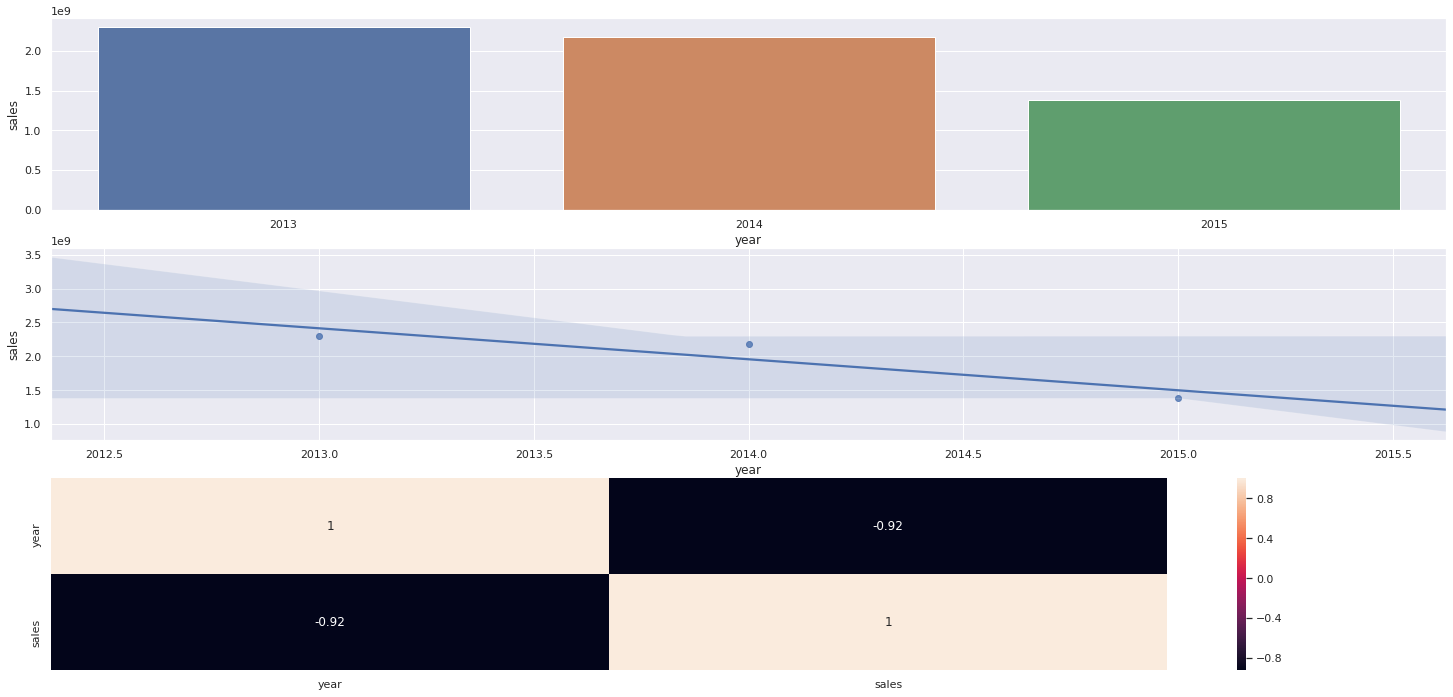

In [67]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

# Gráfico de Barras para comprar o valor das vendas entre os anos
plt.subplot(3, 1, 1)
sns.barplot(x='year', y='sales', data=aux1);

# Gráfico de Tendencia para verificarmos qual a tendencia das vendas ao longo dos anos
plt.subplot(3, 1, 2)
sns.regplot(x='year', y='sales', data=aux1);

# Mapa de Calor para verificarmos a correlação entre o anos e as vendas
plt.subplot(3, 1, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### 4.2.9. Lojas deveriam vender mais no segundo semestre do ano
**FALSA** Lojas vendem menos no segundo semestre do ano

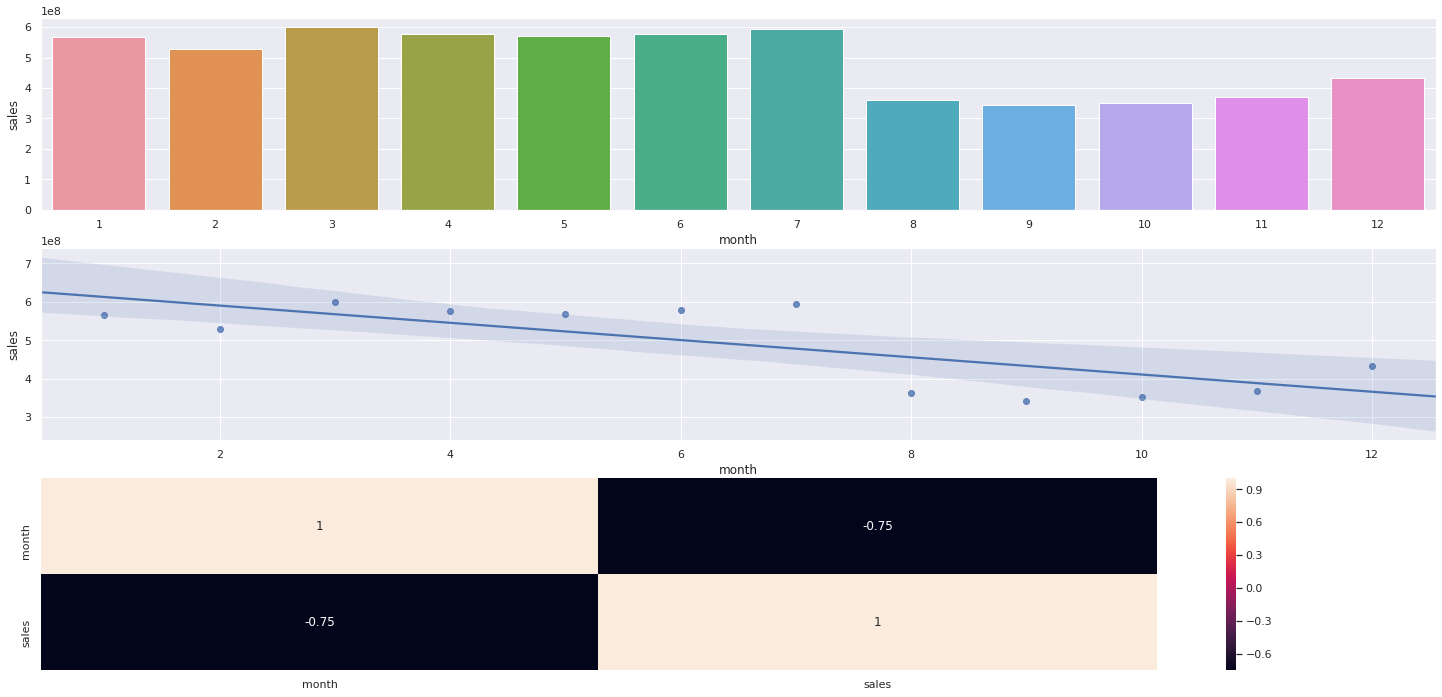

In [68]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

# Gráfico de Barras para comprar as vendas ao longo dos meses do ano
plt.subplot(3, 1, 1)
sns.barplot(x='month', y='sales', data=aux1);

# Gráfoico de Tendencia para verificarmos a tendencia de vendas ao longo dos meses do ano
plt.subplot(3, 1, 2)
sns.regplot(x='month', y='sales', data=aux1);

# Mapa de Calor para verificarmos a correlação entre o mês do ano e o valor de vendas
plt.subplot(3, 1, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### 4.2.10. Lojas deveriam vender mais depois do dia 10 de cada mês
**VERDADEIRA** Lojas Vendem MAIS depois do dia 10 de cada mês

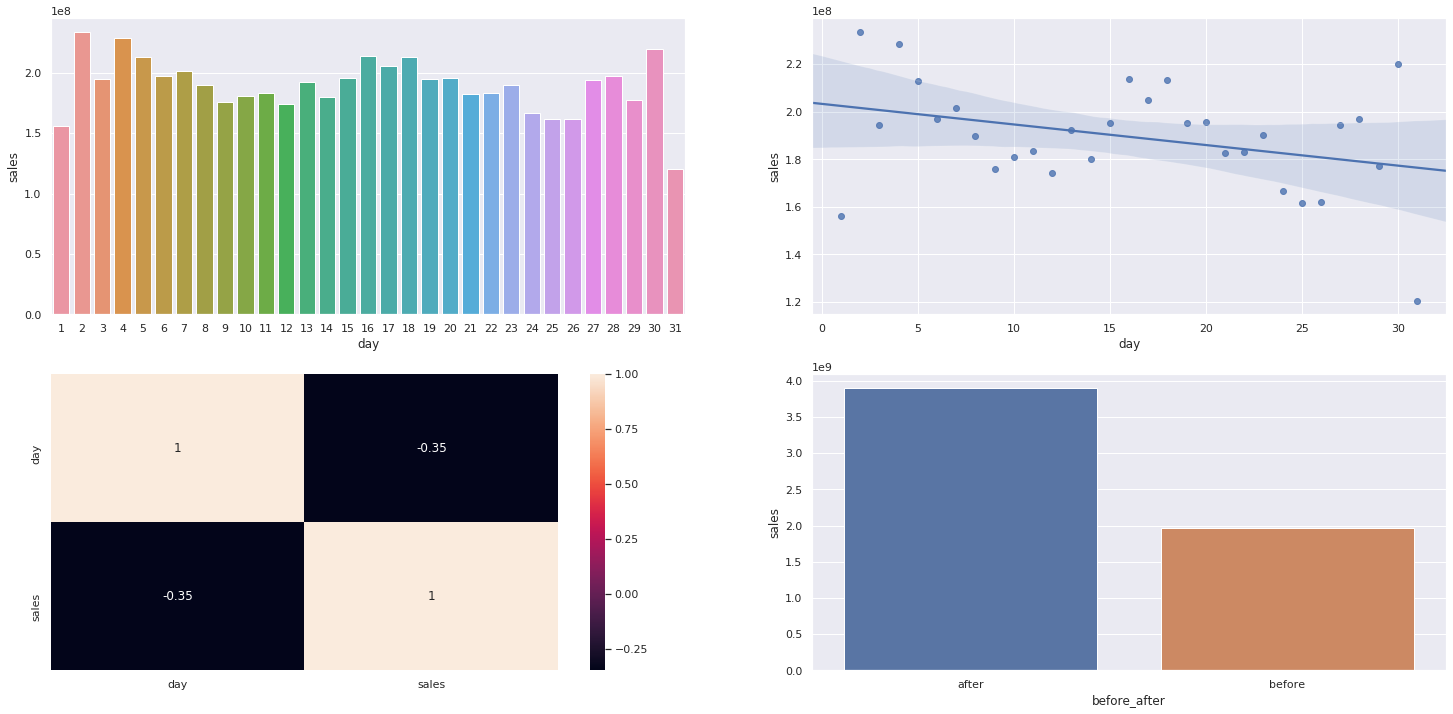

In [69]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

# Gráfico de Barras para comparar as vendas ao longo dos dias do Mês
plt.subplot(2, 2, 1)
sns.barplot(x='day', y='sales', data=aux1);

# Gráfico de Tendencia para verificarmos a tendencia de vendas ao longo dos dias do Mês
plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1);

# Mapa de Calor para verificarmos a correlação entre o dia do mês e o valor de vendas
plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


# Criação e filtragem de uma nova coluna para separarmos os dias antes e depois do dia 10
aux1['before_after'] = aux1['day'].apply(lambda x: 'before' if x <= 10 else 'after')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

# Gráfico de Barras para comprar as vendas antes e depois do dia 10
plt.subplot(2, 2, 4)
sns.barplot(x='before_after', y='sales', data=aux2);

### 4.2.11. Lojas deveriam vender menos aos finais de semana
**VERDADEIRA** Lojas vendem menos aos finais de semana

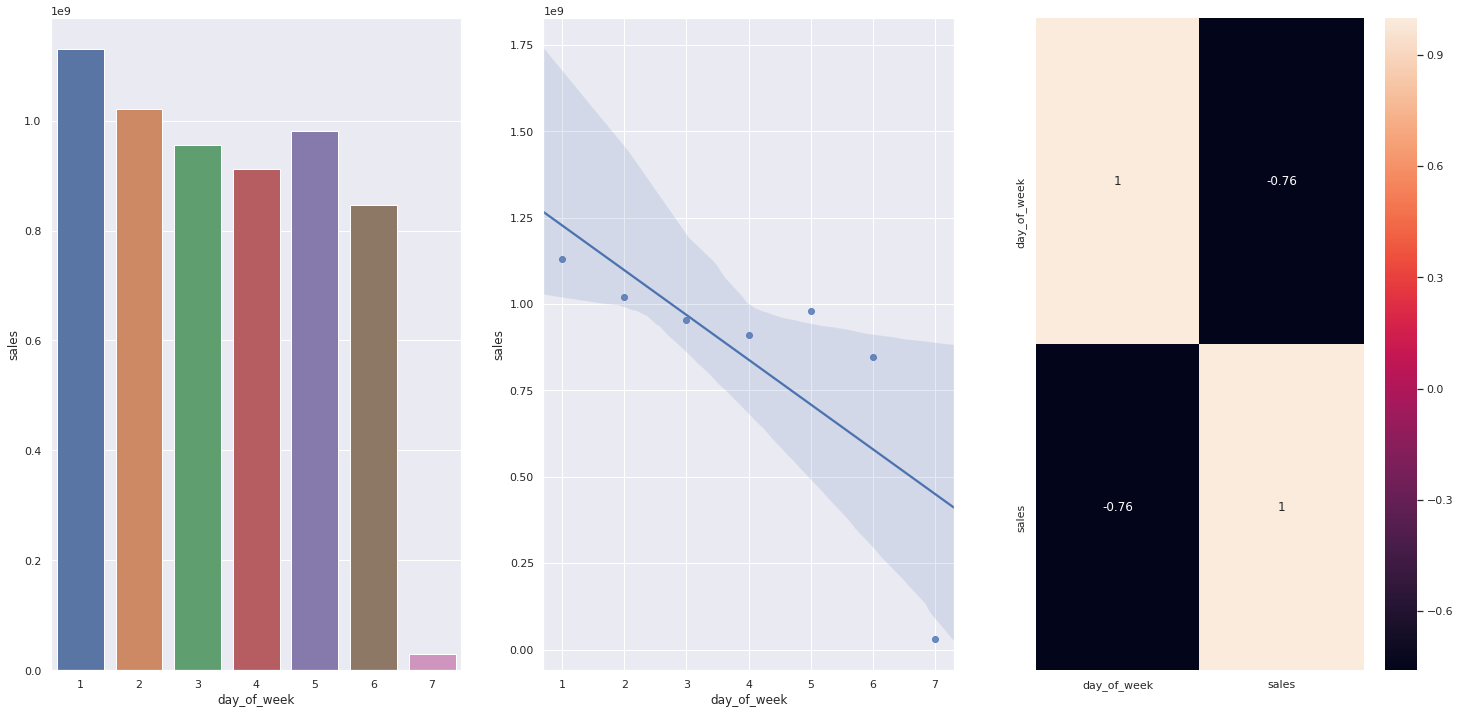

In [70]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

# Gráfico de Barras para verificarmos qual dia da semana vende mais
plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

# Gráfico de Tendencia para verificarmos a tendencia de vendas ao longo dos dias da semana
plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

# Mapa de Calor para verificarmos a correlação entre os dias da semana e o valor de vendas
plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### 4.2.12. Lojas deveriam vender menos durante os feriados escolares
**VERDADEIRA** Lojas vendem menos durante os feriados escolares, exceto em Julho e Agosto

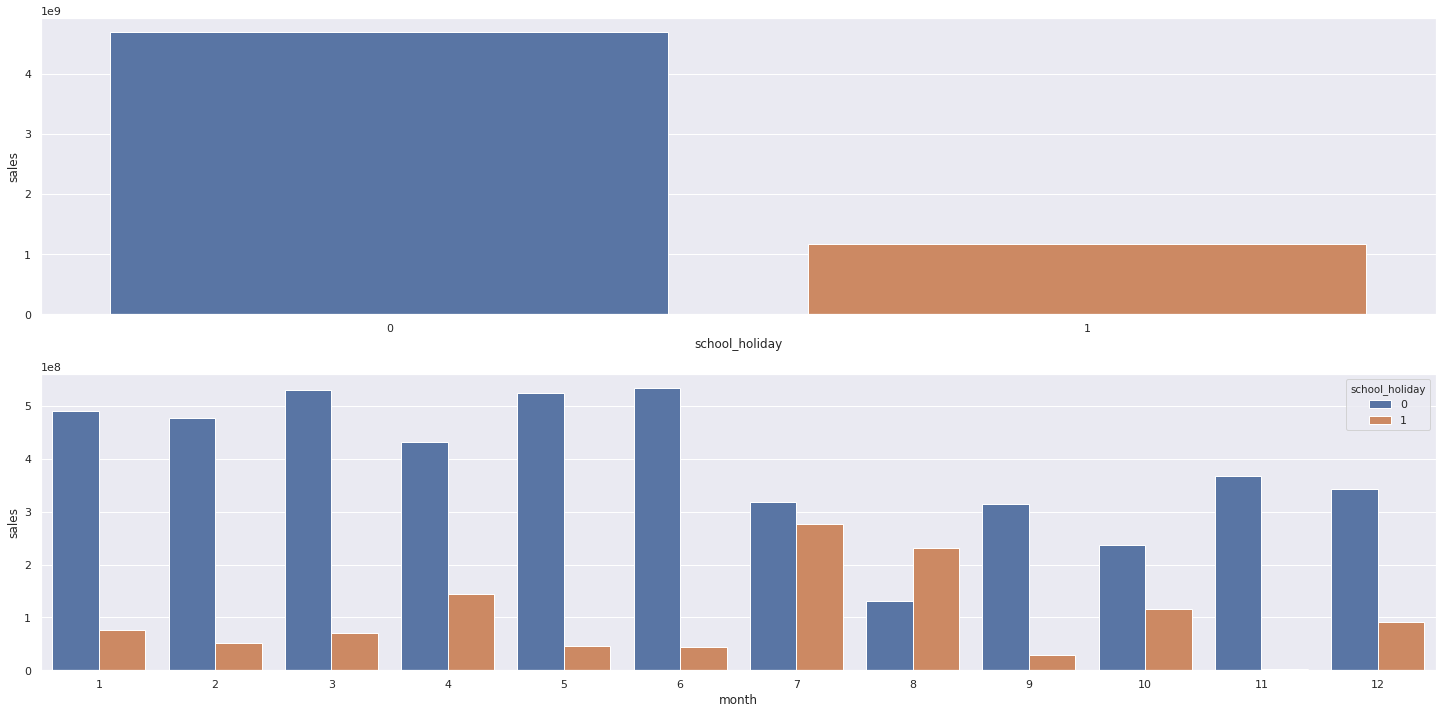

In [71]:
# Gráfico de Barras para verificarmos o valor de vendas entre os dias normais e feriados escolares
plt.subplot(2, 1, 1)
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x='school_holiday', y='sales', data=aux1);

# Gráfico de Barras para verificarmos o valor de vendas entre os dias normais e feriados escolares ao longo do mes
plt.subplot(2, 1, 2)
aux2= df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

### 4.2.13. Hypotesis Resume

In [72]:
tab = [
    ['Hypotesis', 'Conclusion', 'Relevance'],
    ['H1', 'False', 'Low'],
    ['H2', 'False', 'Medium'],
    ['H3', 'False', 'Medium'],
    ['H4', 'False', 'Low'],
    ['H5', '-', '-'],
    ['H6', 'False', 'Low'],
    ['H7', 'False', 'Medium'],
    ['H8', 'False', 'High'],
    ['H9', 'False', 'High'],
    ['H10', 'True', 'High'],
    ['H11', 'True', 'High'],
    ['H12', 'True', 'Low'],
      ]

In [73]:
print(tabulate(tab, headers='firstrow'))

Hypotesis    Conclusion    Relevance
-----------  ------------  -----------
H1           False         Low
H2           False         Medium
H3           False         Medium
H4           False         Low
H5           -             -
H6           False         Low
H7           False         Medium
H8           False         High
H9           False         High
H10          True          High
H11          True          High
H12          True          Low


## 4.3. Multivariate analysis

### 4.3.1. Numerical Attributes 

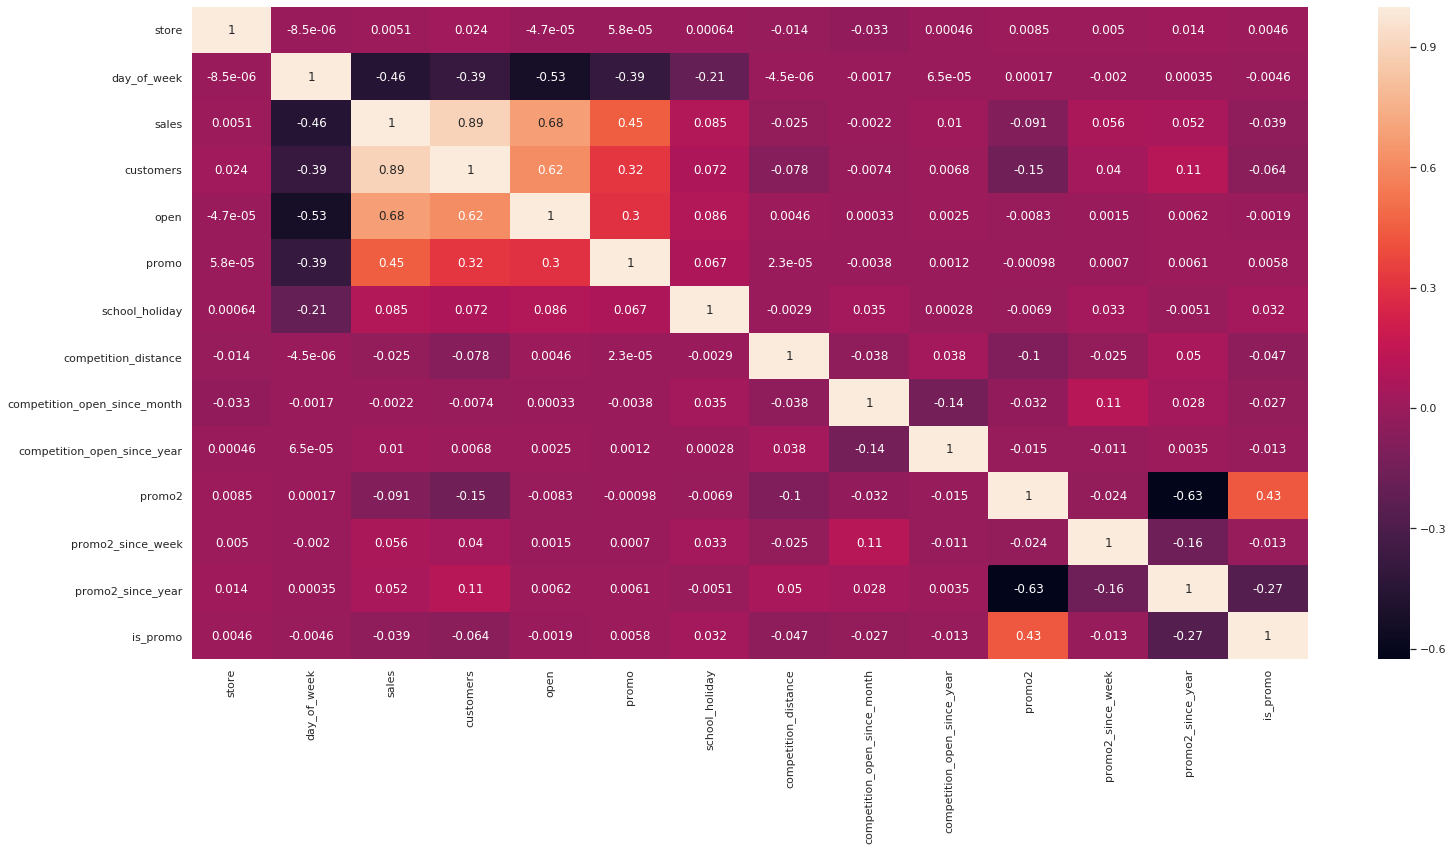

In [74]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 4.3.2. Categorical Attributes

<ipython-input-2-fed45f3dee70>:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  cm = pd.crosstab(x, y).as_matrix()


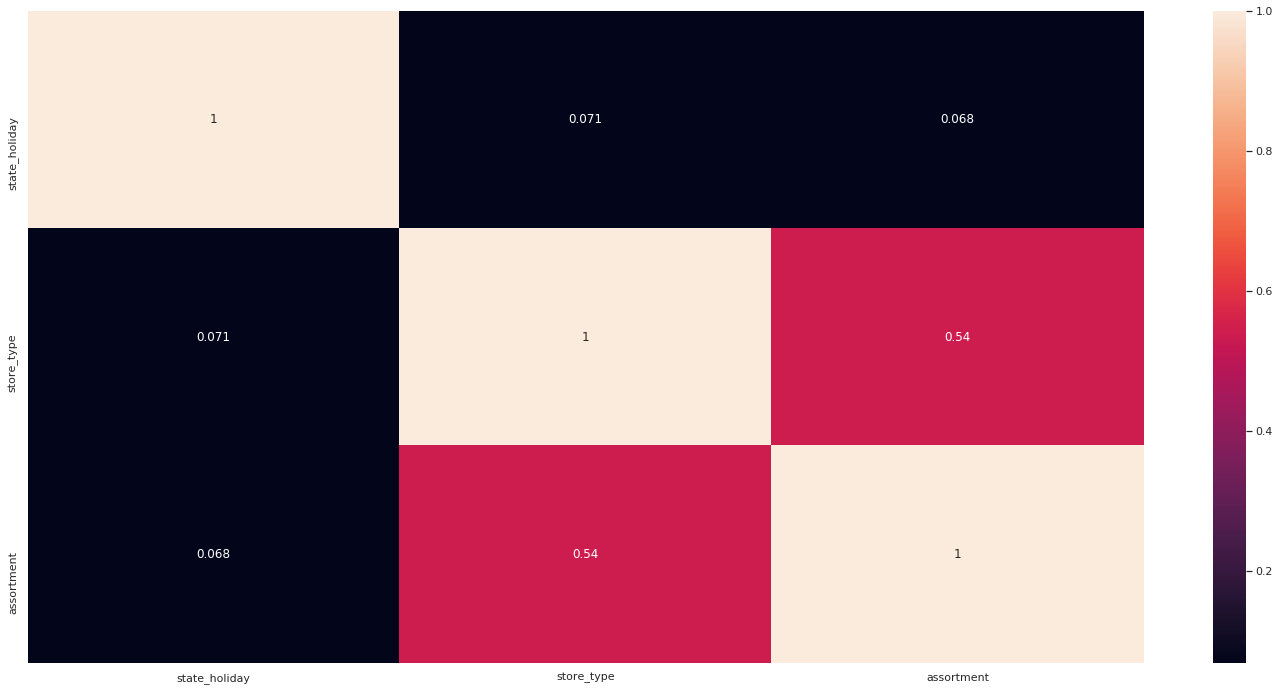

In [75]:
# Selecionando somente Dados Categóricos
cat = df4.select_dtypes(include='object')

# Calcula Cramer V
a1 = cramer_v(cat['state_holiday'], cat['state_holiday'])
a2 = cramer_v(cat['state_holiday'], cat['store_type'])
a3 = cramer_v(cat['state_holiday'], cat['assortment'])

a4 = cramer_v(cat['store_type'], cat['state_holiday'])
a5 = cramer_v(cat['store_type'], cat['store_type'])
a6 = cramer_v(cat['store_type'], cat['assortment'])

a7 = cramer_v(cat['assortment'], cat['state_holiday'])
a8 = cramer_v(cat['assortment'], cat['store_type'])
a9 = cramer_v(cat['assortment'], cat['assortment'])

# Dataset Final
df = pd.DataFrame({'state_holiday': [a1, a2, a3],
                   'store_type': [a4, a5, a6],
                   'assortment': [a7, a8, a9],
                  })
df = df.set_index(df.columns)

# Mapa de Calor para verificar a correlação entre as variáveis categóricas
sns.heatmap(df, annot=True);

# 5.0. DATA PREPARATION

In [76]:
df5 = df4.copy()

## 5.1. Normalization

Foi Realizada a observação das variáveis numéricas, no item 4.1.2. e concluímos que não temos nenhuma variável com uma distribuição normal (Gaussiana). Dessa forma, não será feita a normalização de nenhuma variável.

## 5.2. Rescaling

In [77]:
# Criando o Objeto de Robust Scaler
rs = RobustScaler()

# Criando o Objeto Min Max Scaler
mms = MinMaxScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

# year
df5['year'] = mms.fit_transform(df5[['year']].values)

## 5.3. Transformation

### 5.3.1. Encoding

In [78]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

#store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2. Response Variable Transformation

In [79]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3. Nature Transformation

In [80]:
# month - Ciclo de 12 Meses
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

# day - Ciclo de 30 Dias
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

# week_of_year - Ciclo de 52 semanas
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

# day_of_week - Ciclo de 7 dias
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

# 6.0. VARIABLE SELECTION

In [81]:
df6 = df5.copy()

## 6.1. Split Dataframe into Training and Test

In [82]:
# Sempre que criamos/derivamos colunas com base em uma variável, a variável original deve ser apagada
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']

df6 = df6.drop(cols_drop, axis=1)

In [84]:
# Verificação dá data do primeiro dia das últimas 6 semanas - 6 semanas vezes 7 dias da semana = 42 dias
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days = 6 * 7)

Timestamp('2015-06-19 00:00:00')

In [85]:
# Training Dataset
X_train = df6[df6['date'] < '2015-06-19']
Y_train = X_train['sales']

# Teste Dataset
X_test = df6[df6['date'] >= '2015-06-19']
Y_test = X_test['sales']

In [86]:
# Verificação da separação
print(f"Train Min Date: {X_train['date'].min()}")
print(f"Train Max Date: {X_train['date'].max()}")

print(f"\nTest Min Date: {X_test['date'].min()}")
print(f"Test Max Date: {X_test['date'].max()}")

Train Min Date: 2013-01-01 00:00:00
Train Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [89]:
# Training and test dataset for boruta
X_train_n = X_train.drop(['sales', 'date'], axis = 1).values
Y_train_n = Y_train.values.ravel()  # Devolve como um vetor

In [91]:
# Define Random Forest Regressor
rf = RandomForestRegressor(n_jobs = -1)  # Passamos -1 para que ele utilize o máximo possível da máquina

In [92]:
# Define Boruta
# Deixamos o estimator como automático para que o algoritmo escolha automaticamente os melhores parêmtros
# Verbose igual a 2 faz com que o algoritmo printe o que o seu processo
# Definimos o random_state com um valor para que ele parte sempre do mesmo ponto na aleatoriedade
# boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, Y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


In [93]:
# Seleciona os indices das colunas selecionadas pelo Boruta
cols_selected = boruta.support_.tolist()

In [95]:
# Como removemos as colunas 'sales' e 'date' do dataset de treinamento,
# precisamos remove-las novamente para podermos comprar com os resultados
# do Boruta, a fim de descobrir o nome das variáveis
X_train_fs = X_train.drop(['date', 'sales'], axis = 1)

In [105]:
# Best Features
# =============
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.tolist()

In [106]:
# Not Selected Features
# =====================
# Estamos selecionando as colunas que foram entendidas como não relevantes
cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

## 6.3. Manual Feature Selection

In [104]:
# Após a selecção feita pelo Boruta, primeiro nós temos que analisar essa seleção e
# Comparar com a tabela que criamos parar analisar as hipóteses que possuem mais
# relevância em nossa opinião, e depois fazer um merge dessas variáveis com as 
# variáeis selecionadas pelo Boruta.
# Após isso, criamos manualmente uma lista com todas as variáveis selecionadas por
# nós e pelo Boruta para que não precisemos rodar o algoritmo sempre que fecharmos
# o nosso notebook.

In [100]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos',
    'day_of_week_sin',
    'day_of_week_cos'
]

In [101]:
# Columns to add
feat_to_add = ['date', 'sales']

In [102]:
# Final Features
cols_selected_boruta.extend(feat_to_add)